In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import seaborn as sns
import pandas as pd
import configs

device = 'cpu'

In [2]:
def format_model_name(key):
    if key == 'rnn':
        return 'RNN-SF'
    elif key == 'rnn_oja':
        return 'RNN-Oja'
    elif key == 'linear':
        return 'Linear'
    elif key == 'mlp':
        return 'MLP with Replay Buffer'
    else:
        raise ValueError("Invalid key.")

In [3]:
def get_sparsity(key):
    p = re.compile('.*sparsity(.+?)\/.*')
    if 'sparsity' in key:
        m = p.match(key)
        return m.group(1)
    else:
        return '0'

def get_sigma(key):
    p = re.compile('.*sigma(.+?)\/.*')
    if 'sigma' in key:
        m = p.match(key)
        return m.group(1)
    else:
        return '0'

In [4]:
hue_order = [
    #'Linear',
    'RNN-SF',
    'MLP with Replay Buffer',
    #'RNN-Oja',
    #'Linear'
    #'RNN with Fixed LR', 'RNN with Dynamic LR',
    ]

# Collect aggregate metrics

In [5]:
# Collect measures of all iterations
root_dir = "/home/chingf/engram/Ching/03_td_discrete_corr/"

init_sparsities = []
final_sparsities = []
sigmas = []
gammas = []
models = []
start_losses = []
time_to_elbows = []
final_losses = []
chance_losses = []

for sparsity_dir in os.listdir(root_dir):
    if 'sparsity' not in sparsity_dir: continue
    for sigma_dir in os.listdir(f'{root_dir}{sparsity_dir}/'):
        for gamma_dir in os.listdir(f'{root_dir}{sparsity_dir}/{sigma_dir}/'):
            path = f'{root_dir}{sparsity_dir}/{sigma_dir}/{gamma_dir}/'
            print(path)
            
            # Get dataset parameters
            init_sparsity = get_sparsity(path)
            sigma = get_sigma(path)
            gamma = float(gamma_dir)
            
            # Iterate over models
            for model_dir in os.listdir(path):
                try:
                    model = format_model_name(model_dir)
                except:
                    continue
                model_path = f'{path}{model_dir}/'
                    
                # Gather metrics for each model iteration
                for iter_dir in os.listdir(model_path):
                    iter_path = model_path + iter_dir + '/'
                    if not os.path.isfile(iter_path + 'results.p'):
                        continue
                    for file in os.listdir(iter_path):
                        print(file)
                        if 'tfevents' not in file: continue
                        tfevents_file = iter_path + '/' + file
                        event_acc = EventAccumulator(tfevents_file)
                        event_acc.Reload()
                        try:
                            scalar_events = event_acc.Scalars('loss_train')
                        except:
                            continue
                        values = np.array([event.value for event in scalar_events])
                        if np.any(np.isnan(values)): continue
                        steps = np.array([event.step for event in scalar_events])
                        central_diffs = values[1:] + values[:-1] - 2*values[:-1]
                        if values[0] > values[-1]: # decreasing
                            val95 = values[0] - abs(values[0] - values[-1])*0.95
                            time_to_95 = np.argwhere(values <= val95)[0][0]
                        else: # increasing
                            val95 = values[-1] - abs(values[0] - values[-1])*0.95
                            time_to_95 = np.argwhere(values >= val95)[0][0]
                        
                        init_sparsities.append(init_sparsity)
                        results = pickle.load(open(iter_path + 'results.p', 'rb'))
                        final_sparsities.append(results['dset'].feature_maker.post_smooth_sparsity)
                        sigmas.append(sigma)
                        gammas.append(gamma)
                        models.append(model)
                        start_losses.append(values[0])
                        time_to_elbows.append(steps[time_to_95])
                        #time_to_elbows.append(steps[np.argmax(central_diffs)])
                        final_losses.append(values[-1])
                        if 'mlp' in model_dir:
                            chance_losses.append(np.nan)
                        else:
                            chance_losses.append(event_acc.Scalars('chance_loss')[-1].value)
                        break

init_sparsities = np.array(init_sparsities)
final_sparsities = np.array(final_sparsities)
sigmas = np.array(sigmas)
gammas = np.array(gammas)
models = np.array(models)
start_losses = np.array(start_losses)
time_to_elbows = np.array(time_to_elbows)
final_losses = np.array(final_losses)
chance_losses = np.array(chance_losses)

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.0448421052631579/sigma1.5/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1641563957.mushroombody.aronov.zi.columbia.edu.43084.139
results.p
model.pt
field_infos.p
events.out.tfevents.1641563791.mushroombody.aronov.zi.columbia.edu.43084.137
results.p
model.pt
field_infos.p
events.out.tfevents.1641563875.mushroombody.aronov.zi.columbia.edu.43084.138
results.p
model.pt
events.out.tfevents.1641560186.mushroombody.aronov.zi.columbia.edu.43084.129
results.p
model.pt
field_infos.p
events.out.tfevents.1641553237.mushroombody.aronov.zi.columbia.edu.43084.127
results.p
model.pt
field_infos.p
events.out.tfevents.1641556695.mushroombody.aronov.zi.columbia.edu.43084.128
results.p
events.out.tfevents.1641563783.mushroombody.aronov.zi.columbia.edu.43084.136
results.p
model.pt
field_infos.p
events.out.tfevents.1641563766.mushroombody.aronov.zi.columbia.edu.43084.134
results.p
events.out.tfevents.1641563774.mushroombody.aronov.zi.columb

results.p
events.out.tfevents.1641771235.mushroombody.aronov.zi.columbia.edu.14603.8
events.out.tfevents.1641773257.mushroombody.aronov.zi.columbia.edu.14603.16
events.out.tfevents.1641773238.mushroombody.aronov.zi.columbia.edu.14603.14
results.p
model.pt
field_infos.p
events.out.tfevents.1641773247.mushroombody.aronov.zi.columbia.edu.14603.15
results.p
model.pt
field_infos.p
events.out.tfevents.1641768466.mushroombody.aronov.zi.columbia.edu.14603.4
results.p
model.pt
field_infos.p
events.out.tfevents.1641766766.mushroombody.aronov.zi.columbia.edu.14603.2
results.p
model.pt
field_infos.p
events.out.tfevents.1641767599.mushroombody.aronov.zi.columbia.edu.14603.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021842105263157895/sigma1.0/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641281081.mushroombody.aronov.zi.columbia.edu.34102.19
results.p
model.pt
field_infos.p
events.out.tfevents.1641280869.mushroombody.aronov.zi.columbia.edu.34102.17
results.p
events.out.t

results.p
model.pt
field_infos.p
events.out.tfevents.1641476228.mushroombody.aronov.zi.columbia.edu.56671.17
results.p
events.out.tfevents.1641476316.mushroombody.aronov.zi.columbia.edu.56671.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641474578.mushroombody.aronov.zi.columbia.edu.56671.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641471477.mushroombody.aronov.zi.columbia.edu.56671.7
results.p
events.out.tfevents.1641473013.mushroombody.aronov.zi.columbia.edu.56671.8
results.p
events.out.tfevents.1641476219.mushroombody.aronov.zi.columbia.edu.56671.16
events.out.tfevents.1641476200.mushroombody.aronov.zi.columbia.edu.56671.14
results.p
model.pt
field_infos.p
events.out.tfevents.1641476210.mushroombody.aronov.zi.columbia.edu.56671.15
results.p
events.out.tfevents.1641468189.mushroombody.aronov.zi.columbia.edu.56671.4
results.p
model.pt
field_infos.p
events.out.tfevents.1641465075.mushroombody.aronov.zi.columbia.edu.56671.2
events.out.tfevents.1641466635.mushroomb

results.p
events.out.tfevents.1641305142.mushroombody.aronov.zi.columbia.edu.34071.35
results.p
model.pt
events.out.tfevents.1641290051.mushroombody.aronov.zi.columbia.edu.34071.24
results.p
model.pt
field_infos.p
events.out.tfevents.1641284043.mushroombody.aronov.zi.columbia.edu.34071.22
results.p
model.pt
field_infos.p
events.out.tfevents.1641287034.mushroombody.aronov.zi.columbia.edu.34071.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.019526315789473683/sigma1.75/0.8/
results.p
events.out.tfevents.1641564775.mushroombody.aronov.zi.columbia.edu.43093.139
results.p
events.out.tfevents.1641564607.mushroombody.aronov.zi.columbia.edu.43093.137
events.out.tfevents.1641564689.mushroombody.aronov.zi.columbia.edu.43093.138
results.p
events.out.tfevents.1641561011.mushroombody.aronov.zi.columbia.edu.43093.129
results.p
model.pt
field_infos.p
events.out.tfevents.1641554033.mushroombody.aronov.zi.columbia.edu.43093.127
results.p
model.pt
events.out.tfevents.1641557513.mushroombody.

events.out.tfevents.1641779500.mushroombody.aronov.zi.columbia.edu.14661.28
results.p
events.out.tfevents.1641781256.mushroombody.aronov.zi.columbia.edu.14661.36
results.p
model.pt
field_infos.p
events.out.tfevents.1641781237.mushroombody.aronov.zi.columbia.edu.14661.34
results.p
model.pt
events.out.tfevents.1641781246.mushroombody.aronov.zi.columbia.edu.14661.35
results.p
model.pt
field_infos.p
events.out.tfevents.1641776673.mushroombody.aronov.zi.columbia.edu.14661.24
results.p
events.out.tfevents.1641774969.mushroombody.aronov.zi.columbia.edu.14661.22
results.p
model.pt
field_infos.p
events.out.tfevents.1641775826.mushroombody.aronov.zi.columbia.edu.14661.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.05589473684210527/sigma0.5/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641439483.mushroombody.aronov.zi.columbia.edu.43069.19
results.p
events.out.tfevents.1641439308.mushroombody.aronov.zi.columbia.edu.43069.17
results.p
model.pt
field_infos.p
events.out.tf

results.p
events.out.tfevents.1641515339.mushroombody.aronov.zi.columbia.edu.43128.98
events.out.tfevents.1641513402.mushroombody.aronov.zi.columbia.edu.43128.89
events.out.tfevents.1641510286.mushroombody.aronov.zi.columbia.edu.43128.87
results.p
events.out.tfevents.1641511846.mushroombody.aronov.zi.columbia.edu.43128.88
events.out.tfevents.1641515244.mushroombody.aronov.zi.columbia.edu.43128.96
results.p
events.out.tfevents.1641515227.mushroombody.aronov.zi.columbia.edu.43128.94
results.p
model.pt
field_infos.p
events.out.tfevents.1641515236.mushroombody.aronov.zi.columbia.edu.43128.95
results.p
model.pt
field_infos.p
events.out.tfevents.1641506932.mushroombody.aronov.zi.columbia.edu.43128.84
results.p
events.out.tfevents.1641503872.mushroombody.aronov.zi.columbia.edu.43128.82
results.p
events.out.tfevents.1641505395.mushroombody.aronov.zi.columbia.edu.43128.83
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03/sigma2.5/0.4/
results.p
model.pt
field_infos.p
events.out.tfevent

results.p
model.pt
events.out.tfevents.1641445535.mushroombody.aronov.zi.columbia.edu.43071.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.06373684210526316/sigma0.5/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1641535698.mushroombody.aronov.zi.columbia.edu.43103.119
results.p
model.pt
events.out.tfevents.1641535546.mushroombody.aronov.zi.columbia.edu.43103.117
results.p
model.pt
field_infos.p
events.out.tfevents.1641535623.mushroombody.aronov.zi.columbia.edu.43103.118
results.p
model.pt
field_infos.p
events.out.tfevents.1641531877.mushroombody.aronov.zi.columbia.edu.43103.109
results.p
events.out.tfevents.1641524910.mushroombody.aronov.zi.columbia.edu.43103.107
results.p
events.out.tfevents.1641528364.mushroombody.aronov.zi.columbia.edu.43103.108
results.p
model.pt
field_infos.p
events.out.tfevents.1641535538.mushroombody.aronov.zi.columbia.edu.43103.116
results.p
model.pt
field_infos.p
events.out.tfevents.1641535522.mushroombody.aronov.zi.columbia.edu.43103.1

events.out.tfevents.1641797059.mushroombody.aronov.zi.columbia.edu.14647.75
results.p
model.pt
field_infos.p
events.out.tfevents.1641792439.mushroombody.aronov.zi.columbia.edu.14647.64
results.p
events.out.tfevents.1641790710.mushroombody.aronov.zi.columbia.edu.14647.62
results.p
events.out.tfevents.1641791566.mushroombody.aronov.zi.columbia.edu.14647.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.00863157894736842/sigma2.5/0.75/
results.p
events.out.tfevents.1641462995.mushroombody.aronov.zi.columbia.edu.43116.39
results.p
model.pt
field_infos.p
events.out.tfevents.1641462800.mushroombody.aronov.zi.columbia.edu.43116.37
results.p
events.out.tfevents.1641462901.mushroombody.aronov.zi.columbia.edu.43116.38
results.p
model.pt
field_infos.p
events.out.tfevents.1641459882.mushroombody.aronov.zi.columbia.edu.43116.29
results.p
model.pt
field_infos.p
events.out.tfevents.1641454363.mushroombody.aronov.zi.columbia.edu.43116.27
results.p
events.out.tfevents.1641457133.mushroombody.a

results.p
events.out.tfevents.1641502333.mushroombody.aronov.zi.columbia.edu.43072.74
results.p
model.pt
events.out.tfevents.1641502342.mushroombody.aronov.zi.columbia.edu.43072.75
results.p
model.pt
field_infos.p
events.out.tfevents.1641490422.mushroombody.aronov.zi.columbia.edu.43072.64
results.p
model.pt
field_infos.p
events.out.tfevents.1641487276.mushroombody.aronov.zi.columbia.edu.43072.62
events.out.tfevents.1641488816.mushroombody.aronov.zi.columbia.edu.43072.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03573684210526316/sigma1.75/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641789706.mushroombody.aronov.zi.columbia.edu.14584.59
results.p
model.pt
field_infos.p
events.out.tfevents.1641789495.mushroombody.aronov.zi.columbia.edu.14584.57
results.p
model.pt
field_infos.p
events.out.tfevents.1641789601.mushroombody.aronov.zi.columbia.edu.14584.58
events.out.tfevents.1641788485.mushroombody.aronov.zi.columbia.edu.14584.49
results.p
model.pt
field_infos.p


results.p
model.pt
field_infos.p
events.out.tfevents.1641580180.mushroombody.aronov.zi.columbia.edu.43102.148
events.out.tfevents.1641583492.mushroombody.aronov.zi.columbia.edu.43102.156
results.p
model.pt
field_infos.p
events.out.tfevents.1641583484.mushroombody.aronov.zi.columbia.edu.43102.154
results.p
events.out.tfevents.1641583488.mushroombody.aronov.zi.columbia.edu.43102.155
results.p
model.pt
field_infos.p
events.out.tfevents.1641575138.mushroombody.aronov.zi.columbia.edu.43102.144
results.p
model.pt
field_infos.p
events.out.tfevents.1641570166.mushroombody.aronov.zi.columbia.edu.43102.142
events.out.tfevents.1641573389.mushroombody.aronov.zi.columbia.edu.43102.143
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021210526315789475/sigma2.75/0.6/
events.out.tfevents.1641516299.mushroombody.aronov.zi.columbia.edu.43111.99
results.p
model.pt
field_infos.p
events.out.tfevents.1641516119.mushroombody.aronov.zi.columbia.edu.43111.97
results.p
events.out.tfevents.1641516210.mus

results.p
model.pt
field_infos.p
events.out.tfevents.1641439101.mushroombody.aronov.zi.columbia.edu.43092.17
results.p
events.out.tfevents.1641439185.mushroombody.aronov.zi.columbia.edu.43092.18
events.out.tfevents.1641436343.mushroombody.aronov.zi.columbia.edu.43092.9
results.p
events.out.tfevents.1641430963.mushroombody.aronov.zi.columbia.edu.43092.7
results.p
events.out.tfevents.1641433685.mushroombody.aronov.zi.columbia.edu.43092.8
events.out.tfevents.1641439092.mushroombody.aronov.zi.columbia.edu.43092.16
events.out.tfevents.1641439076.mushroombody.aronov.zi.columbia.edu.43092.14
results.p
model.pt
field_infos.p
events.out.tfevents.1641439084.mushroombody.aronov.zi.columbia.edu.43092.15
results.p
model.pt
field_infos.p
events.out.tfevents.1641425021.mushroombody.aronov.zi.columbia.edu.43092.4
results.p
model.pt
field_infos.p
events.out.tfevents.1641419685.mushroombody.aronov.zi.columbia.edu.43092.2
results.p
model.pt
field_infos.p
events.out.tfevents.1641422334.mushroombody.aronov

results.p
model.pt
events.out.tfevents.1641797106.mushroombody.aronov.zi.columbia.edu.18475.17
results.p
events.out.tfevents.1641797212.mushroombody.aronov.zi.columbia.edu.18475.18
events.out.tfevents.1641796141.mushroombody.aronov.zi.columbia.edu.18475.9
events.out.tfevents.1641794391.mushroombody.aronov.zi.columbia.edu.18475.7
results.p
events.out.tfevents.1641795258.mushroombody.aronov.zi.columbia.edu.18475.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641797096.mushroombody.aronov.zi.columbia.edu.18475.16
results.p
model.pt
events.out.tfevents.1641797077.mushroombody.aronov.zi.columbia.edu.18475.14
results.p
model.pt
field_infos.p
events.out.tfevents.1641797087.mushroombody.aronov.zi.columbia.edu.18475.15
results.p
events.out.tfevents.1641792418.mushroombody.aronov.zi.columbia.edu.18475.4
results.p
model.pt
events.out.tfevents.1641790689.mushroombody.aronov.zi.columbia.edu.18475.2
events.out.tfevents.1641791546.mushroombody.aronov.zi.columbia.edu.18475.3
/home/chingf/engr

results.p
model.pt
field_infos.p
events.out.tfevents.1641682632.mushroombody.aronov.zi.columbia.edu.10880.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.00731578947368421/sigma3.25/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1641688607.mushroombody.aronov.zi.columbia.edu.10834.19
results.p
model.pt
field_infos.p
events.out.tfevents.1641688394.mushroombody.aronov.zi.columbia.edu.10834.17
events.out.tfevents.1641688485.mushroombody.aronov.zi.columbia.edu.10834.18
events.out.tfevents.1641686818.mushroombody.aronov.zi.columbia.edu.10834.9
events.out.tfevents.1641683594.mushroombody.aronov.zi.columbia.edu.10834.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641685065.mushroombody.aronov.zi.columbia.edu.10834.8
events.out.tfevents.1641688386.mushroombody.aronov.zi.columbia.edu.10834.16
results.p
model.pt
field_infos.p
events.out.tfevents.1641688369.mushroombody.aronov.zi.columbia.edu.10834.14
results.p
model.pt
field_infos.p
events.out.tfevents.1641688378.mu

results.p
events.out.tfevents.1641484905.mushroombody.aronov.zi.columbia.edu.43097.56
events.out.tfevents.1641484889.mushroombody.aronov.zi.columbia.edu.43097.54
events.out.tfevents.1641484897.mushroombody.aronov.zi.columbia.edu.43097.55
events.out.tfevents.1641470941.mushroombody.aronov.zi.columbia.edu.43097.44
events.out.tfevents.1641465469.mushroombody.aronov.zi.columbia.edu.43097.42
results.p
events.out.tfevents.1641468173.mushroombody.aronov.zi.columbia.edu.43097.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.01931578947368421/sigma2.5/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1641581958.mushroombody.aronov.zi.columbia.edu.43133.159
results.p
model.pt
field_infos.p
events.out.tfevents.1641581849.mushroombody.aronov.zi.columbia.edu.43133.157
events.out.tfevents.1641581905.mushroombody.aronov.zi.columbia.edu.43133.158
results.p
events.out.tfevents.1641580240.mushroombody.aronov.zi.columbia.edu.43133.149
results.p
model.pt
field_infos.p
events.out.tfevents

results.p
events.out.tfevents.1641779520.mushroombody.aronov.zi.columbia.edu.14618.28
results.p
model.pt
field_infos.p
events.out.tfevents.1641781287.mushroombody.aronov.zi.columbia.edu.14618.36
results.p
events.out.tfevents.1641781271.mushroombody.aronov.zi.columbia.edu.14618.34
results.p
model.pt
field_infos.p
events.out.tfevents.1641781279.mushroombody.aronov.zi.columbia.edu.14618.35
results.p
model.pt
events.out.tfevents.1641776667.mushroombody.aronov.zi.columbia.edu.14618.24
results.p
events.out.tfevents.1641774936.mushroombody.aronov.zi.columbia.edu.14618.22
results.p
model.pt
field_infos.p
events.out.tfevents.1641775808.mushroombody.aronov.zi.columbia.edu.14618.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.01836842105263158/sigma3.0/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641304975.mushroombody.aronov.zi.columbia.edu.34132.39
results.p
model.pt
field_infos.p
events.out.tfevents.1641304781.mushroombody.aronov.zi.columbia.edu.34132.37
results.p
mod

events.out.tfevents.1641488427.mushroombody.aronov.zi.columbia.edu.43088.69
results.p
model.pt
field_infos.p
events.out.tfevents.1641485230.mushroombody.aronov.zi.columbia.edu.43088.67
results.p
model.pt
field_infos.p
events.out.tfevents.1641486845.mushroombody.aronov.zi.columbia.edu.43088.68
results.p
model.pt
field_infos.p
events.out.tfevents.1641490095.mushroombody.aronov.zi.columbia.edu.43088.76
results.p
model.pt
field_infos.p
events.out.tfevents.1641490078.mushroombody.aronov.zi.columbia.edu.43088.74
results.p
model.pt
field_infos.p
events.out.tfevents.1641490086.mushroombody.aronov.zi.columbia.edu.43088.75
results.p
events.out.tfevents.1641481885.mushroombody.aronov.zi.columbia.edu.43088.64
events.out.tfevents.1641478727.mushroombody.aronov.zi.columbia.edu.43088.62
results.p
events.out.tfevents.1641480317.mushroombody.aronov.zi.columbia.edu.43088.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03452631578947368/sigma1.5/0.4/
results.p
model.pt
field_infos.p
events.out

results.p
model.pt
field_infos.p
events.out.tfevents.1641422464.mushroombody.aronov.zi.columbia.edu.43102.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03510526315789474/sigma2.25/0.8/
results.p
model.pt
events.out.tfevents.1641573077.mushroombody.aronov.zi.columbia.edu.43098.139
results.p
events.out.tfevents.1641572951.mushroombody.aronov.zi.columbia.edu.43098.137
results.p
model.pt
field_infos.p
events.out.tfevents.1641573019.mushroombody.aronov.zi.columbia.edu.43098.138
results.p
events.out.tfevents.1641569532.mushroombody.aronov.zi.columbia.edu.43098.129
results.p
model.pt
field_infos.p
events.out.tfevents.1641562500.mushroombody.aronov.zi.columbia.edu.43098.127
results.p
events.out.tfevents.1641566033.mushroombody.aronov.zi.columbia.edu.43098.128
results.p
model.pt
field_infos.p
events.out.tfevents.1641572943.mushroombody.aronov.zi.columbia.edu.43098.136
results.p
model.pt
field_infos.p
events.out.tfevents.1641572927.mushroombody.aronov.zi.columbia.edu.43098.134
result

events.out.tfevents.1641771246.mushroombody.aronov.zi.columbia.edu.14592.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641773272.mushroombody.aronov.zi.columbia.edu.14592.16
results.p
events.out.tfevents.1641773252.mushroombody.aronov.zi.columbia.edu.14592.14
events.out.tfevents.1641773262.mushroombody.aronov.zi.columbia.edu.14592.15
results.p
model.pt
field_infos.p
events.out.tfevents.1641768467.mushroombody.aronov.zi.columbia.edu.14592.4
results.p
model.pt
field_infos.p
events.out.tfevents.1641766766.mushroombody.aronov.zi.columbia.edu.14592.2
results.p
model.pt
field_infos.p
events.out.tfevents.1641767601.mushroombody.aronov.zi.columbia.edu.14592.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.09526315789473684/sigma0.0/0.75/
results.p
events.out.tfevents.1641280973.mushroombody.aronov.zi.columbia.edu.34081.19
results.p
model.pt
field_infos.p
events.out.tfevents.1641280770.mushroombody.aronov.zi.columbia.edu.34081.17
results.p
events.out.tfevents.1641280871.mushr

results.p
model.pt
events.out.tfevents.1641309094.mushroombody.aronov.zi.columbia.edu.34093.58
results.p
model.pt
field_infos.p
events.out.tfevents.1641307293.mushroombody.aronov.zi.columbia.edu.34093.49
events.out.tfevents.1641303850.mushroombody.aronov.zi.columbia.edu.34093.47
events.out.tfevents.1641305547.mushroombody.aronov.zi.columbia.edu.34093.48
results.p
model.pt
events.out.tfevents.1641308999.mushroombody.aronov.zi.columbia.edu.34093.56
results.p
events.out.tfevents.1641308981.mushroombody.aronov.zi.columbia.edu.34093.54
results.p
model.pt
field_infos.p
events.out.tfevents.1641308990.mushroombody.aronov.zi.columbia.edu.34093.55
results.p
model.pt
field_infos.p
events.out.tfevents.1641300484.mushroombody.aronov.zi.columbia.edu.34093.44
results.p
model.pt
field_infos.p
events.out.tfevents.1641297083.mushroombody.aronov.zi.columbia.edu.34093.42
results.p
events.out.tfevents.1641298798.mushroombody.aronov.zi.columbia.edu.34093.43
/home/chingf/engram/Ching/03_td_discrete_corr/spar

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.031105263157894733/sigma1.75/0.8/
results.p
events.out.tfevents.1641565099.mushroombody.aronov.zi.columbia.edu.43077.139
events.out.tfevents.1641564936.mushroombody.aronov.zi.columbia.edu.43077.137
results.p
model.pt
field_infos.p
events.out.tfevents.1641565017.mushroombody.aronov.zi.columbia.edu.43077.138
results.p
model.pt
events.out.tfevents.1641561286.mushroombody.aronov.zi.columbia.edu.43077.129
results.p
model.pt
field_infos.p
events.out.tfevents.1641554252.mushroombody.aronov.zi.columbia.edu.43077.127
events.out.tfevents.1641557737.mushroombody.aronov.zi.columbia.edu.43077.128
results.p
model.pt
field_infos.p
events.out.tfevents.1641564927.mushroombody.aronov.zi.columbia.edu.43077.136
results.p
model.pt
events.out.tfevents.1641564911.mushroombody.aronov.zi.columbia.edu.43077.134
events.out.tfevents.1641564919.mushroombody.aronov.zi.columbia.edu.43077.135
events.out.tfevents.1641547024.mushroombody.aronov.zi.columbia.edu.430

results.p
model.pt
field_infos.p
events.out.tfevents.1641768487.mushroombody.aronov.zi.columbia.edu.14587.4
events.out.tfevents.1641766747.mushroombody.aronov.zi.columbia.edu.14587.2
results.p
model.pt
field_infos.p
events.out.tfevents.1641767602.mushroombody.aronov.zi.columbia.edu.14587.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.1266842105263158/sigma0.0/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641280808.mushroombody.aronov.zi.columbia.edu.34082.19
results.p
model.pt
field_infos.p
events.out.tfevents.1641280613.mushroombody.aronov.zi.columbia.edu.34082.17
results.p
model.pt
field_infos.p
events.out.tfevents.1641280720.mushroombody.aronov.zi.columbia.edu.34082.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641277619.mushroombody.aronov.zi.columbia.edu.34082.9
results.p
events.out.tfevents.1641271438.mushroombody.aronov.zi.columbia.edu.34082.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641274718.mushroombody.aronov.zi.columbia.edu.3

results.p
model.pt
field_infos.p
events.out.tfevents.1641305990.mushroombody.aronov.zi.columbia.edu.34083.48
results.p
model.pt
field_infos.p
events.out.tfevents.1641309552.mushroombody.aronov.zi.columbia.edu.34083.56
results.p
model.pt
field_infos.p
events.out.tfevents.1641309530.mushroombody.aronov.zi.columbia.edu.34083.54
events.out.tfevents.1641309540.mushroombody.aronov.zi.columbia.edu.34083.55
results.p
model.pt
events.out.tfevents.1641300878.mushroombody.aronov.zi.columbia.edu.34083.44
results.p
events.out.tfevents.1641297547.mushroombody.aronov.zi.columbia.edu.34083.42
events.out.tfevents.1641299217.mushroombody.aronov.zi.columbia.edu.34083.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03178947368421053/sigma2.0/0.4/
events.out.tfevents.1641773417.mushroombody.aronov.zi.columbia.edu.14660.19
results.p
events.out.tfevents.1641773170.mushroombody.aronov.zi.columbia.edu.14660.17
results.p
model.pt
events.out.tfevents.1641773289.mushroombody.aronov.zi.columbia.edu.1466

results.p
model.pt
field_infos.p
events.out.tfevents.1641533478.mushroombody.aronov.zi.columbia.edu.43112.107
results.p
model.pt
field_infos.p
events.out.tfevents.1641537013.mushroombody.aronov.zi.columbia.edu.43112.108
results.p
model.pt
field_infos.p
events.out.tfevents.1641543996.mushroombody.aronov.zi.columbia.edu.43112.116
results.p
model.pt
field_infos.p
events.out.tfevents.1641543978.mushroombody.aronov.zi.columbia.edu.43112.114
results.p
model.pt
field_infos.p
events.out.tfevents.1641543987.mushroombody.aronov.zi.columbia.edu.43112.115
results.p
model.pt
field_infos.p
events.out.tfevents.1641526214.mushroombody.aronov.zi.columbia.edu.43112.104
events.out.tfevents.1641519332.mushroombody.aronov.zi.columbia.edu.43112.102
results.p
model.pt
field_infos.p
events.out.tfevents.1641522753.mushroombody.aronov.zi.columbia.edu.43112.103
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.05721052631578947/sigma1.25/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1641489297.

results.p
model.pt
events.out.tfevents.1641280606.mushroombody.aronov.zi.columbia.edu.34071.17
results.p
model.pt
field_infos.p
events.out.tfevents.1641280721.mushroombody.aronov.zi.columbia.edu.34071.18
results.p
events.out.tfevents.1641277617.mushroombody.aronov.zi.columbia.edu.34071.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641271395.mushroombody.aronov.zi.columbia.edu.34071.7
events.out.tfevents.1641274685.mushroombody.aronov.zi.columbia.edu.34071.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641280596.mushroombody.aronov.zi.columbia.edu.34071.16
results.p
model.pt
field_infos.p
events.out.tfevents.1641280578.mushroombody.aronov.zi.columbia.edu.34071.14
events.out.tfevents.1641280587.mushroombody.aronov.zi.columbia.edu.34071.15
events.out.tfevents.1641264698.mushroombody.aronov.zi.columbia.edu.34071.4
results.p
model.pt
field_infos.p
events.out.tfevents.1641257987.mushroombody.aronov.zi.columbia.edu.34071.2
results.p
model.pt
field_infos.p
events.out.tfevent

results.p
events.out.tfevents.1641283326.mushroombody.aronov.zi.columbia.edu.34130.22
events.out.tfevents.1641285069.mushroombody.aronov.zi.columbia.edu.34130.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03226315789473684/sigma1.0/0.4/
events.out.tfevents.1641773645.mushroombody.aronov.zi.columbia.edu.14608.19
results.p
events.out.tfevents.1641773421.mushroombody.aronov.zi.columbia.edu.14608.17
results.p
model.pt
field_infos.p
events.out.tfevents.1641773532.mushroombody.aronov.zi.columbia.edu.14608.18
results.p
events.out.tfevents.1641772256.mushroombody.aronov.zi.columbia.edu.14608.9
events.out.tfevents.1641770480.mushroombody.aronov.zi.columbia.edu.14608.7
results.p
events.out.tfevents.1641771362.mushroombody.aronov.zi.columbia.edu.14608.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641773411.mushroombody.aronov.zi.columbia.edu.14608.16
results.p
model.pt
field_infos.p
events.out.tfevents.1641773390.mushroombody.aronov.zi.columbia.edu.14608.14
results.p
model.

results.p
model.pt
field_infos.p
events.out.tfevents.1641572157.mushroombody.aronov.zi.columbia.edu.43129.136
results.p
model.pt
field_infos.p
events.out.tfevents.1641572143.mushroombody.aronov.zi.columbia.edu.43129.134
results.p
model.pt
field_infos.p
events.out.tfevents.1641572150.mushroombody.aronov.zi.columbia.edu.43129.135
results.p
model.pt
field_infos.p
events.out.tfevents.1641554516.mushroombody.aronov.zi.columbia.edu.43129.124
events.out.tfevents.1641547628.mushroombody.aronov.zi.columbia.edu.43129.122
results.p
events.out.tfevents.1641551048.mushroombody.aronov.zi.columbia.edu.43129.123
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.012368421052631577/sigma2.25/0.6/
events.out.tfevents.1641506248.mushroombody.aronov.zi.columbia.edu.43070.99
results.p
model.pt
events.out.tfevents.1641506086.mushroombody.aronov.zi.columbia.edu.43070.97
events.out.tfevents.1641506165.mushroombody.aronov.zi.columbia.edu.43070.98
results.p
model.pt
field_infos.p
events.out.tfevents.164150

results.p
model.pt
field_infos.p
events.out.tfevents.1641295985.mushroombody.aronov.zi.columbia.edu.34082.27
results.p
model.pt
field_infos.p
events.out.tfevents.1641299034.mushroombody.aronov.zi.columbia.edu.34082.28
events.out.tfevents.1641305003.mushroombody.aronov.zi.columbia.edu.34082.36
results.p
events.out.tfevents.1641304986.mushroombody.aronov.zi.columbia.edu.34082.34
events.out.tfevents.1641304994.mushroombody.aronov.zi.columbia.edu.34082.35
results.p
events.out.tfevents.1641290053.mushroombody.aronov.zi.columbia.edu.34082.24
results.p
model.pt
field_infos.p
events.out.tfevents.1641284026.mushroombody.aronov.zi.columbia.edu.34082.22
events.out.tfevents.1641287037.mushroombody.aronov.zi.columbia.edu.34082.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.017210526315789475/sigma1.75/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1641564856.mushroombody.aronov.zi.columbia.edu.43126.139
results.p
model.pt
field_infos.p
events.out.tfevents.1641564689.mushroomb

results.p
model.pt
field_infos.p
events.out.tfevents.1641789477.mushroombody.aronov.zi.columbia.edu.14614.57
results.p
model.pt
field_infos.p
events.out.tfevents.1641789584.mushroombody.aronov.zi.columbia.edu.14614.58
results.p
model.pt
field_infos.p
events.out.tfevents.1641788471.mushroombody.aronov.zi.columbia.edu.14614.49
results.p
model.pt
field_infos.p
events.out.tfevents.1641786740.mushroombody.aronov.zi.columbia.edu.14614.47
results.p
model.pt
events.out.tfevents.1641787595.mushroombody.aronov.zi.columbia.edu.14614.48
results.p
model.pt
field_infos.p
events.out.tfevents.1641789466.mushroombody.aronov.zi.columbia.edu.14614.56
results.p
model.pt
field_infos.p
events.out.tfevents.1641789445.mushroombody.aronov.zi.columbia.edu.14614.54
results.p
model.pt
field_infos.p
events.out.tfevents.1641789456.mushroombody.aronov.zi.columbia.edu.14614.55
results.p
events.out.tfevents.1641784738.mushroombody.aronov.zi.columbia.edu.14614.44
events.out.tfevents.1641783021.mushroombody.aronov.zi.co

results.p
events.out.tfevents.1641582119.mushroombody.aronov.zi.columbia.edu.2360.75
results.p
model.pt
field_infos.p
events.out.tfevents.1641574202.mushroombody.aronov.zi.columbia.edu.2360.64
results.p
events.out.tfevents.1641568292.mushroombody.aronov.zi.columbia.edu.2360.62
results.p
events.out.tfevents.1641571789.mushroombody.aronov.zi.columbia.edu.2360.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.02389473684210526/sigma2.5/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1641515102.mushroombody.aronov.zi.columbia.edu.43138.99
results.p
events.out.tfevents.1641514928.mushroombody.aronov.zi.columbia.edu.43138.97
results.p
model.pt
field_infos.p
events.out.tfevents.1641515017.mushroombody.aronov.zi.columbia.edu.43138.98
results.p
events.out.tfevents.1641513096.mushroombody.aronov.zi.columbia.edu.43138.89
events.out.tfevents.1641509996.mushroombody.aronov.zi.columbia.edu.43138.87
results.p
model.pt
field_infos.p
events.out.tfevents.1641511522.mushroombody.aronov

results.p
model.pt
field_infos.p
events.out.tfevents.1641431214.mushroombody.aronov.zi.columbia.edu.43093.7
results.p
events.out.tfevents.1641433963.mushroombody.aronov.zi.columbia.edu.43093.8
results.p
events.out.tfevents.1641439465.mushroombody.aronov.zi.columbia.edu.43093.16
results.p
model.pt
field_infos.p
events.out.tfevents.1641439446.mushroombody.aronov.zi.columbia.edu.43093.14
results.p
model.pt
field_infos.p
events.out.tfevents.1641439455.mushroombody.aronov.zi.columbia.edu.43093.15
events.out.tfevents.1641425206.mushroombody.aronov.zi.columbia.edu.43093.4
results.p
model.pt
field_infos.p
events.out.tfevents.1641419777.mushroombody.aronov.zi.columbia.edu.43093.2
results.p
model.pt
events.out.tfevents.1641422497.mushroombody.aronov.zi.columbia.edu.43093.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.016157894736842104/sigma2.25/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1641572809.mushroombody.aronov.zi.columbia.edu.1334.79
events.out.tfevents.16415726

events.out.tfevents.1641789208.mushroombody.aronov.zi.columbia.edu.14646.58
events.out.tfevents.1641788169.mushroombody.aronov.zi.columbia.edu.14646.49
results.p
model.pt
field_infos.p
events.out.tfevents.1641786480.mushroombody.aronov.zi.columbia.edu.14646.47
results.p
model.pt
field_infos.p
events.out.tfevents.1641787328.mushroombody.aronov.zi.columbia.edu.14646.48
results.p
model.pt
field_infos.p
events.out.tfevents.1641789101.mushroombody.aronov.zi.columbia.edu.14646.56
results.p
events.out.tfevents.1641789083.mushroombody.aronov.zi.columbia.edu.14646.54
results.p
events.out.tfevents.1641789092.mushroombody.aronov.zi.columbia.edu.14646.55
events.out.tfevents.1641784512.mushroombody.aronov.zi.columbia.edu.14646.44
results.p
model.pt
field_infos.p
events.out.tfevents.1641782815.mushroombody.aronov.zi.columbia.edu.14646.42
results.p
model.pt
field_infos.p
events.out.tfevents.1641783670.mushroombody.aronov.zi.columbia.edu.14646.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.005578947368421052/sigma2.5/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1641506673.mushroombody.aronov.zi.columbia.edu.43117.99
results.p
events.out.tfevents.1641506492.mushroombody.aronov.zi.columbia.edu.43117.97
results.p
events.out.tfevents.1641506583.mushroombody.aronov.zi.columbia.edu.43117.98
events.out.tfevents.1641504841.mushroombody.aronov.zi.columbia.edu.43117.89
results.p
model.pt
field_infos.p
events.out.tfevents.1641501340.mushroombody.aronov.zi.columbia.edu.43117.87
results.p
events.out.tfevents.1641503204.mushroombody.aronov.zi.columbia.edu.43117.88
results.p
model.pt
field_infos.p
events.out.tfevents.1641506484.mushroombody.aronov.zi.columbia.edu.43117.96
results.p
model.pt
field_infos.p
events.out.tfevents.1641506467.mushroombody.aronov.zi.columbia.edu.43117.94
results.p
events.out.tfevents.1641506475.mushroombody.aronov.zi.columbia.edu.43117.95
results.p
events.out.tfevents.1641496361.mushroombody.a

results.p
model.pt
field_infos.p
events.out.tfevents.1641289702.mushroombody.aronov.zi.columbia.edu.34141.24
results.p
model.pt
events.out.tfevents.1641283767.mushroombody.aronov.zi.columbia.edu.34141.22
results.p
events.out.tfevents.1641286731.mushroombody.aronov.zi.columbia.edu.34141.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.13431578947368422/sigma0.5/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1641535854.mushroombody.aronov.zi.columbia.edu.43090.119
results.p
model.pt
field_infos.p
events.out.tfevents.1641535700.mushroombody.aronov.zi.columbia.edu.43090.117
events.out.tfevents.1641535777.mushroombody.aronov.zi.columbia.edu.43090.118
events.out.tfevents.1641532096.mushroombody.aronov.zi.columbia.edu.43090.109
results.p
events.out.tfevents.1641525169.mushroombody.aronov.zi.columbia.edu.43090.107
events.out.tfevents.1641528624.mushroombody.aronov.zi.columbia.edu.43090.108
results.p
events.out.tfevents.1641535692.mushroombody.aronov.zi.columbia.edu.43090.1

results.p
model.pt
field_infos.p
events.out.tfevents.1641789117.mushroombody.aronov.zi.columbia.edu.14633.54
results.p
model.pt
events.out.tfevents.1641789127.mushroombody.aronov.zi.columbia.edu.14633.55
results.p
events.out.tfevents.1641784571.mushroombody.aronov.zi.columbia.edu.14633.44
results.p
model.pt
events.out.tfevents.1641782876.mushroombody.aronov.zi.columbia.edu.14633.42
results.p
model.pt
events.out.tfevents.1641783728.mushroombody.aronov.zi.columbia.edu.14633.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.04226315789473684/sigma1.5/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641461560.mushroombody.aronov.zi.columbia.edu.43135.39
results.p
events.out.tfevents.1641461398.mushroombody.aronov.zi.columbia.edu.43135.37
results.p
model.pt
field_infos.p
events.out.tfevents.1641461481.mushroombody.aronov.zi.columbia.edu.43135.38
events.out.tfevents.1641458609.mushroombody.aronov.zi.columbia.edu.43135.29
events.out.tfevents.1641453252.mushroombody.aronov.

results.p
events.out.tfevents.1641484584.mushroombody.aronov.zi.columbia.edu.43120.67
results.p
model.pt
field_infos.p
events.out.tfevents.1641486183.mushroombody.aronov.zi.columbia.edu.43120.68
results.p
events.out.tfevents.1641489363.mushroombody.aronov.zi.columbia.edu.43120.76
results.p
model.pt
field_infos.p
events.out.tfevents.1641489346.mushroombody.aronov.zi.columbia.edu.43120.74
results.p
model.pt
events.out.tfevents.1641489354.mushroombody.aronov.zi.columbia.edu.43120.75
results.p
model.pt
field_infos.p
events.out.tfevents.1641481285.mushroombody.aronov.zi.columbia.edu.43120.64
results.p
model.pt
field_infos.p
events.out.tfevents.1641478167.mushroombody.aronov.zi.columbia.edu.43120.62
results.p
model.pt
field_infos.p
events.out.tfevents.1641479709.mushroombody.aronov.zi.columbia.edu.43120.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.008736842105263157/sigma1.5/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641789301.mushroombody.aronov.zi.columbia.edu

results.p
model.pt
field_infos.p
events.out.tfevents.1641342945.mushroombody.aronov.zi.columbia.edu.34123.77
results.p
model.pt
field_infos.p
events.out.tfevents.1641343190.mushroombody.aronov.zi.columbia.edu.34123.78
results.p
model.pt
field_infos.p
events.out.tfevents.1641336926.mushroombody.aronov.zi.columbia.edu.34123.69
events.out.tfevents.1641328512.mushroombody.aronov.zi.columbia.edu.34123.67
results.p
model.pt
field_infos.p
events.out.tfevents.1641332687.mushroombody.aronov.zi.columbia.edu.34123.68
events.out.tfevents.1641342929.mushroombody.aronov.zi.columbia.edu.34123.76
events.out.tfevents.1641342876.mushroombody.aronov.zi.columbia.edu.34123.74
events.out.tfevents.1641342906.mushroombody.aronov.zi.columbia.edu.34123.75
results.p
model.pt
field_infos.p
events.out.tfevents.1641320842.mushroombody.aronov.zi.columbia.edu.34123.64
results.p
events.out.tfevents.1641313296.mushroombody.aronov.zi.columbia.edu.34123.62
results.p
events.out.tfevents.1641317039.mushroombody.aronov.zi.c

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.011421052631578946/sigma1.0/0.75/
events.out.tfevents.1641280948.mushroombody.aronov.zi.columbia.edu.34093.19
events.out.tfevents.1641280761.mushroombody.aronov.zi.columbia.edu.34093.17
results.p
model.pt
field_infos.p
events.out.tfevents.1641280855.mushroombody.aronov.zi.columbia.edu.34093.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641277735.mushroombody.aronov.zi.columbia.edu.34093.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641271625.mushroombody.aronov.zi.columbia.edu.34093.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641274847.mushroombody.aronov.zi.columbia.edu.34093.8
events.out.tfevents.1641280752.mushroombody.aronov.zi.columbia.edu.34093.16
results.p
model.pt
field_infos.p
events.out.tfevents.1641280733.mushroombody.aronov.zi.columbia.edu.34093.14
results.p
model.pt
field_infos.p
events.out.tfevents.1641280742.mushroombody.aronov.zi.columbia.edu.34093.15
results.p
model.pt
field_infos.

events.out.tfevents.1641506538.mushroombody.aronov.zi.columbia.edu.2360.15
results.p
model.pt
field_infos.p
events.out.tfevents.1641496570.mushroombody.aronov.zi.columbia.edu.2360.4
results.p
model.pt
field_infos.p
events.out.tfevents.1641491704.mushroombody.aronov.zi.columbia.edu.2360.2
results.p
events.out.tfevents.1641494126.mushroombody.aronov.zi.columbia.edu.2360.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.002526315789473684/sigma2.5/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641797238.mushroombody.aronov.zi.columbia.edu.14635.79
events.out.tfevents.1641797030.mushroombody.aronov.zi.columbia.edu.14635.77
results.p
events.out.tfevents.1641797135.mushroombody.aronov.zi.columbia.edu.14635.78
results.p
events.out.tfevents.1641796081.mushroombody.aronov.zi.columbia.edu.14635.69
results.p
events.out.tfevents.1641794351.mushroombody.aronov.zi.columbia.edu.14635.67
results.p
model.pt
field_infos.p
events.out.tfevents.1641795211.mushroombody.aronov.zi.columbia

events.out.tfevents.1641525206.mushroombody.aronov.zi.columbia.edu.43075.107
results.p
events.out.tfevents.1641528671.mushroombody.aronov.zi.columbia.edu.43075.108
events.out.tfevents.1641535813.mushroombody.aronov.zi.columbia.edu.43075.116
results.p
model.pt
field_infos.p
events.out.tfevents.1641535796.mushroombody.aronov.zi.columbia.edu.43075.114
results.p
model.pt
field_infos.p
events.out.tfevents.1641535804.mushroombody.aronov.zi.columbia.edu.43075.115
results.p
model.pt
field_infos.p
events.out.tfevents.1641517994.mushroombody.aronov.zi.columbia.edu.43075.104
events.out.tfevents.1641510673.mushroombody.aronov.zi.columbia.edu.43075.102
events.out.tfevents.1641514446.mushroombody.aronov.zi.columbia.edu.43075.103
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.10294736842105263/sigma0.5/0.6/
events.out.tfevents.1641476076.mushroombody.aronov.zi.columbia.edu.43077.59
events.out.tfevents.1641475919.mushroombody.aronov.zi.columbia.edu.43077.57
results.p
model.pt
field_infos.p
ev

results.p
events.out.tfevents.1641439401.mushroombody.aronov.zi.columbia.edu.43109.18
events.out.tfevents.1641436505.mushroombody.aronov.zi.columbia.edu.43109.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641431078.mushroombody.aronov.zi.columbia.edu.43109.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641433816.mushroombody.aronov.zi.columbia.edu.43109.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641439295.mushroombody.aronov.zi.columbia.edu.43109.16
results.p
events.out.tfevents.1641439276.mushroombody.aronov.zi.columbia.edu.43109.14
results.p
model.pt
field_infos.p
events.out.tfevents.1641439285.mushroombody.aronov.zi.columbia.edu.43109.15
events.out.tfevents.1641425085.mushroombody.aronov.zi.columbia.edu.43109.4
results.p
model.pt
events.out.tfevents.1641419704.mushroombody.aronov.zi.columbia.edu.43109.2
events.out.tfevents.1641422383.mushroombody.aronov.zi.columbia.edu.43109.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021526315789473685/

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.009210526315789475/sigma2.0/0.4/
results.p
events.out.tfevents.1641773520.mushroombody.aronov.zi.columbia.edu.14635.19
results.p
events.out.tfevents.1641773255.mushroombody.aronov.zi.columbia.edu.14635.17
results.p
events.out.tfevents.1641773374.mushroombody.aronov.zi.columbia.edu.14635.18
results.p
events.out.tfevents.1641772117.mushroombody.aronov.zi.columbia.edu.14635.9
results.p
events.out.tfevents.1641770389.mushroombody.aronov.zi.columbia.edu.14635.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641771228.mushroombody.aronov.zi.columbia.edu.14635.8
events.out.tfevents.1641773246.mushroombody.aronov.zi.columbia.edu.14635.16
events.out.tfevents.1641773227.mushroombody.aronov.zi.columbia.edu.14635.14
results.p
model.pt
field_infos.p
events.out.tfevents.1641773236.mushroombody.aronov.zi.columbia.edu.14635.15
events.out.tfevents.1641768459.mushroombody.aronov.zi.columbia.edu.14635.4
results.p
events.out.tfevents.164176676

events.out.tfevents.1641352848.mushroombody.aronov.zi.columbia.edu.34083.83
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021842105263157892/sigma3.0/0.6/
results.p
events.out.tfevents.1641319240.mushroombody.aronov.zi.columbia.edu.34107.59
results.p
model.pt
field_infos.p
events.out.tfevents.1641319052.mushroombody.aronov.zi.columbia.edu.34107.57
results.p
model.pt
field_infos.p
events.out.tfevents.1641319148.mushroombody.aronov.zi.columbia.edu.34107.58
results.p
events.out.tfevents.1641317308.mushroombody.aronov.zi.columbia.edu.34107.49
events.out.tfevents.1641313986.mushroombody.aronov.zi.columbia.edu.34107.47
results.p
model.pt
field_infos.p
events.out.tfevents.1641315654.mushroombody.aronov.zi.columbia.edu.34107.48
results.p
model.pt
field_infos.p
events.out.tfevents.1641319042.mushroombody.aronov.zi.columbia.edu.34107.56
results.p
model.pt
field_infos.p
events.out.tfevents.1641319025.mushroombody.aronov.zi.columbia.edu.34107.54
results.p
model.pt
events.out.tfevents.164

events.out.tfevents.1641461785.mushroombody.aronov.zi.columbia.edu.43138.36
results.p
model.pt
events.out.tfevents.1641461769.mushroombody.aronov.zi.columbia.edu.43138.34
results.p
model.pt
field_infos.p
events.out.tfevents.1641461777.mushroombody.aronov.zi.columbia.edu.43138.35
events.out.tfevents.1641448044.mushroombody.aronov.zi.columbia.edu.43138.24
events.out.tfevents.1641442575.mushroombody.aronov.zi.columbia.edu.43138.22
events.out.tfevents.1641445280.mushroombody.aronov.zi.columbia.edu.43138.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.0033157894736842103/sigma3.0/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1641361130.mushroombody.aronov.zi.columbia.edu.34154.79
results.p
model.pt
field_infos.p
events.out.tfevents.1641361019.mushroombody.aronov.zi.columbia.edu.34154.77
results.p
events.out.tfevents.1641361077.mushroombody.aronov.zi.columbia.edu.34154.78
results.p
model.pt
events.out.tfevents.1641359259.mushroombody.aronov.zi.columbia.edu.34154.69
res

results.p
model.pt
field_infos.p
events.out.tfevents.1641786596.mushroombody.aronov.zi.columbia.edu.14588.47
results.p
events.out.tfevents.1641787446.mushroombody.aronov.zi.columbia.edu.14588.48
results.p
model.pt
field_infos.p
events.out.tfevents.1641789248.mushroombody.aronov.zi.columbia.edu.14588.56
results.p
model.pt
field_infos.p
events.out.tfevents.1641789228.mushroombody.aronov.zi.columbia.edu.14588.54
results.p
model.pt
field_infos.p
events.out.tfevents.1641789238.mushroombody.aronov.zi.columbia.edu.14588.55
results.p
events.out.tfevents.1641784613.mushroombody.aronov.zi.columbia.edu.14588.44
events.out.tfevents.1641782903.mushroombody.aronov.zi.columbia.edu.14588.42
results.p
model.pt
field_infos.p
events.out.tfevents.1641783761.mushroombody.aronov.zi.columbia.edu.14588.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.0033157894736842103/sigma1.75/0.75/
results.p
model.pt
events.out.tfevents.1641462313.mushroombody.aronov.zi.columbia.edu.43072.39
results.p
events.out

results.p
events.out.tfevents.1641309058.mushroombody.aronov.zi.columbia.edu.36673.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641307243.mushroombody.aronov.zi.columbia.edu.36673.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641303818.mushroombody.aronov.zi.columbia.edu.36673.7
events.out.tfevents.1641305508.mushroombody.aronov.zi.columbia.edu.36673.8
events.out.tfevents.1641308955.mushroombody.aronov.zi.columbia.edu.36673.16
results.p
model.pt
events.out.tfevents.1641308937.mushroombody.aronov.zi.columbia.edu.36673.14
events.out.tfevents.1641308946.mushroombody.aronov.zi.columbia.edu.36673.15
events.out.tfevents.1641300435.mushroombody.aronov.zi.columbia.edu.36673.4
results.p
model.pt
events.out.tfevents.1641297062.mushroombody.aronov.zi.columbia.edu.36673.2
results.p
events.out.tfevents.1641298760.mushroombody.aronov.zi.columbia.edu.36673.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.07915789473684211/sigma1.0/0.4/
results.p
events.out.tfevents.1641

results.p
model.pt
events.out.tfevents.1641535447.mushroombody.aronov.zi.columbia.edu.43110.117
results.p
model.pt
field_infos.p
events.out.tfevents.1641535519.mushroombody.aronov.zi.columbia.edu.43110.118
events.out.tfevents.1641531814.mushroombody.aronov.zi.columbia.edu.43110.109
events.out.tfevents.1641524867.mushroombody.aronov.zi.columbia.edu.43110.107
results.p
model.pt
field_infos.p
events.out.tfevents.1641528316.mushroombody.aronov.zi.columbia.edu.43110.108
results.p
model.pt
field_infos.p
events.out.tfevents.1641535438.mushroombody.aronov.zi.columbia.edu.43110.116
results.p
model.pt
events.out.tfevents.1641535421.mushroombody.aronov.zi.columbia.edu.43110.114
results.p
model.pt
field_infos.p
events.out.tfevents.1641535430.mushroombody.aronov.zi.columbia.edu.43110.115
results.p
events.out.tfevents.1641517665.mushroombody.aronov.zi.columbia.edu.43110.104
results.p
events.out.tfevents.1641510316.mushroombody.aronov.zi.columbia.edu.43110.102
events.out.tfevents.1641514104.mushroomb

results.p
model.pt
field_infos.p
events.out.tfevents.1641766732.mushroombody.aronov.zi.columbia.edu.14654.2
events.out.tfevents.1641767569.mushroombody.aronov.zi.columbia.edu.14654.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.023578947368421053/sigma2.0/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641280747.mushroombody.aronov.zi.columbia.edu.34154.19
events.out.tfevents.1641280525.mushroombody.aronov.zi.columbia.edu.34154.17
results.p
model.pt
field_infos.p
events.out.tfevents.1641280639.mushroombody.aronov.zi.columbia.edu.34154.18
events.out.tfevents.1641277541.mushroombody.aronov.zi.columbia.edu.34154.9
results.p
events.out.tfevents.1641271378.mushroombody.aronov.zi.columbia.edu.34154.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641274659.mushroombody.aronov.zi.columbia.edu.34154.8
events.out.tfevents.1641280516.mushroombody.aronov.zi.columbia.edu.34154.16
results.p
events.out.tfevents.1641280497.mushroombody.aronov.zi.columbia.edu.34154.14
res

results.p
model.pt
field_infos.p
events.out.tfevents.1641506199.mushroombody.aronov.zi.columbia.edu.43076.96
results.p
model.pt
field_infos.p
events.out.tfevents.1641506182.mushroombody.aronov.zi.columbia.edu.43076.94
results.p
model.pt
field_infos.p
events.out.tfevents.1641506191.mushroombody.aronov.zi.columbia.edu.43076.95
events.out.tfevents.1641495969.mushroombody.aronov.zi.columbia.edu.43076.84
results.p
model.pt
field_infos.p
events.out.tfevents.1641491443.mushroombody.aronov.zi.columbia.edu.43076.82
results.p
model.pt
field_infos.p
events.out.tfevents.1641493718.mushroombody.aronov.zi.columbia.edu.43076.83
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.027526315789473683/sigma2.25/0.4/
events.out.tfevents.1641796956.mushroombody.aronov.zi.columbia.edu.14656.79
results.p
model.pt
events.out.tfevents.1641796789.mushroombody.aronov.zi.columbia.edu.14656.77
results.p
events.out.tfevents.1641796873.mushroombody.aronov.zi.columbia.edu.14656.78
results.p
model.pt
field_infos.p

results.p
model.pt
field_infos.p
events.out.tfevents.1641545008.mushroombody.aronov.zi.columbia.edu.43083.118
results.p
events.out.tfevents.1641541336.mushroombody.aronov.zi.columbia.edu.43083.109
results.p
model.pt
field_infos.p
events.out.tfevents.1641534351.mushroombody.aronov.zi.columbia.edu.43083.107
results.p
events.out.tfevents.1641537851.mushroombody.aronov.zi.columbia.edu.43083.108
results.p
events.out.tfevents.1641544916.mushroombody.aronov.zi.columbia.edu.43083.116
results.p
model.pt
events.out.tfevents.1641544899.mushroombody.aronov.zi.columbia.edu.43083.114
results.p
model.pt
field_infos.p
events.out.tfevents.1641544907.mushroombody.aronov.zi.columbia.edu.43083.115
results.p
model.pt
events.out.tfevents.1641527113.mushroombody.aronov.zi.columbia.edu.43083.104
results.p
model.pt
field_infos.p
events.out.tfevents.1641520155.mushroombody.aronov.zi.columbia.edu.43083.102
results.p
model.pt
events.out.tfevents.1641523634.mushroombody.aronov.zi.columbia.edu.43083.103
/home/ching

events.out.tfevents.1641439313.mushroombody.aronov.zi.columbia.edu.43114.17
events.out.tfevents.1641439413.mushroombody.aronov.zi.columbia.edu.43114.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641436493.mushroombody.aronov.zi.columbia.edu.43114.9
events.out.tfevents.1641431070.mushroombody.aronov.zi.columbia.edu.43114.7
results.p
model.pt
events.out.tfevents.1641433799.mushroombody.aronov.zi.columbia.edu.43114.8
events.out.tfevents.1641439304.mushroombody.aronov.zi.columbia.edu.43114.16
events.out.tfevents.1641439285.mushroombody.aronov.zi.columbia.edu.43114.14
results.p
model.pt
field_infos.p
events.out.tfevents.1641439294.mushroombody.aronov.zi.columbia.edu.43114.15
results.p
model.pt
field_infos.p
events.out.tfevents.1641425080.mushroombody.aronov.zi.columbia.edu.43114.4
results.p
model.pt
field_infos.p
events.out.tfevents.1641419717.mushroombody.aronov.zi.columbia.edu.43114.2
results.p
events.out.tfevents.1641422390.mushroombody.aronov.zi.columbia.edu.43114.3
/home/chi

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.06352631578947368/sigma1.0/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641773662.mushroombody.aronov.zi.columbia.edu.14614.19
results.p
events.out.tfevents.1641773398.mushroombody.aronov.zi.columbia.edu.14614.17
results.p
model.pt
events.out.tfevents.1641773536.mushroombody.aronov.zi.columbia.edu.14614.18
results.p
events.out.tfevents.1641772212.mushroombody.aronov.zi.columbia.edu.14614.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641770467.mushroombody.aronov.zi.columbia.edu.14614.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641771312.mushroombody.aronov.zi.columbia.edu.14614.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641773385.mushroombody.aronov.zi.columbia.edu.14614.16
results.p
events.out.tfevents.1641773362.mushroombody.aronov.zi.columbia.edu.14614.14
events.out.tfevents.1641773373.mushroombody.aronov.zi.columbia.edu.14614.15
results.p
model.pt
events.out.tfevents.1641768501.

events.out.tfevents.1641547594.mushroombody.aronov.zi.columbia.edu.43125.124
results.p
model.pt
field_infos.p
events.out.tfevents.1641540461.mushroombody.aronov.zi.columbia.edu.43125.122
events.out.tfevents.1641543979.mushroombody.aronov.zi.columbia.edu.43125.123
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.04268421052631578/sigma1.75/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1641502530.mushroombody.aronov.zi.columbia.edu.43111.79
results.p
events.out.tfevents.1641502342.mushroombody.aronov.zi.columbia.edu.43111.77
results.p
model.pt
field_infos.p
events.out.tfevents.1641502437.mushroombody.aronov.zi.columbia.edu.43111.78
results.p
model.pt
field_infos.p
events.out.tfevents.1641500095.mushroombody.aronov.zi.columbia.edu.43111.69
results.p
model.pt
field_infos.p
events.out.tfevents.1641495118.mushroombody.aronov.zi.columbia.edu.43111.67
results.p
model.pt
field_infos.p
events.out.tfevents.1641497553.mushroombody.aronov.zi.columbia.edu.43111.68
results.p
model.

results.p
model.pt
field_infos.p
events.out.tfevents.1641271787.mushroombody.aronov.zi.columbia.edu.34076.7
results.p
model.pt
events.out.tfevents.1641275030.mushroombody.aronov.zi.columbia.edu.34076.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641281070.mushroombody.aronov.zi.columbia.edu.34076.16
results.p
events.out.tfevents.1641281050.mushroombody.aronov.zi.columbia.edu.34076.14
results.p
model.pt
field_infos.p
events.out.tfevents.1641281060.mushroombody.aronov.zi.columbia.edu.34076.15
events.out.tfevents.1641264899.mushroombody.aronov.zi.columbia.edu.34076.4
results.p
model.pt
events.out.tfevents.1641258077.mushroombody.aronov.zi.columbia.edu.34076.2
events.out.tfevents.1641261568.mushroombody.aronov.zi.columbia.edu.34076.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.07594736842105262/sigma1.25/0.8/
events.out.tfevents.1641544099.mushroombody.aronov.zi.columbia.edu.43065.119
events.out.tfevents.1641543940.mushroombody.aronov.zi.columbia.edu.43065.117
results

results.p
model.pt
field_infos.p
events.out.tfevents.1641800642.mushroombody.aronov.zi.columbia.edu.14649.98
results.p
model.pt
events.out.tfevents.1641800166.mushroombody.aronov.zi.columbia.edu.14649.89
results.p
events.out.tfevents.1641799391.mushroombody.aronov.zi.columbia.edu.14649.87
results.p
model.pt
field_infos.p
events.out.tfevents.1641799774.mushroombody.aronov.zi.columbia.edu.14649.88
results.p
model.pt
field_infos.p
events.out.tfevents.1641800588.mushroombody.aronov.zi.columbia.edu.14649.96
results.p
model.pt
field_infos.p
events.out.tfevents.1641800577.mushroombody.aronov.zi.columbia.edu.14649.94
events.out.tfevents.1641800583.mushroombody.aronov.zi.columbia.edu.14649.95
events.out.tfevents.1641798535.mushroombody.aronov.zi.columbia.edu.14649.84
events.out.tfevents.1641797737.mushroombody.aronov.zi.columbia.edu.14649.82
results.p
model.pt
field_infos.p
events.out.tfevents.1641798133.mushroombody.aronov.zi.columbia.edu.14649.83
/home/chingf/engram/Ching/03_td_discrete_corr/

results.p
model.pt
events.out.tfevents.1641488882.mushroombody.aronov.zi.columbia.edu.43110.77
results.p
events.out.tfevents.1641488985.mushroombody.aronov.zi.columbia.edu.43110.78
results.p
events.out.tfevents.1641487303.mushroombody.aronov.zi.columbia.edu.43110.69
events.out.tfevents.1641484106.mushroombody.aronov.zi.columbia.edu.43110.67
results.p
model.pt
field_infos.p
events.out.tfevents.1641485725.mushroombody.aronov.zi.columbia.edu.43110.68
results.p
model.pt
field_infos.p
events.out.tfevents.1641488874.mushroombody.aronov.zi.columbia.edu.43110.76
results.p
model.pt
events.out.tfevents.1641488857.mushroombody.aronov.zi.columbia.edu.43110.74
results.p
model.pt
field_infos.p
events.out.tfevents.1641488865.mushroombody.aronov.zi.columbia.edu.43110.75
results.p
model.pt
field_infos.p
events.out.tfevents.1641480843.mushroombody.aronov.zi.columbia.edu.43110.64
results.p
model.pt
field_infos.p
events.out.tfevents.1641477742.mushroombody.aronov.zi.columbia.edu.43110.62
events.out.tfeven

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.02705263157894737/sigma1.0/0.8/
results.p
events.out.tfevents.1641346930.mushroombody.aronov.zi.columbia.edu.34084.79
results.p
events.out.tfevents.1641346516.mushroombody.aronov.zi.columbia.edu.34084.77
results.p
model.pt
field_infos.p
events.out.tfevents.1641346719.mushroombody.aronov.zi.columbia.edu.34084.78
results.p
events.out.tfevents.1641337998.mushroombody.aronov.zi.columbia.edu.34084.69
results.p
events.out.tfevents.1641329281.mushroombody.aronov.zi.columbia.edu.34084.67
results.p
model.pt
field_infos.p
events.out.tfevents.1641333667.mushroombody.aronov.zi.columbia.edu.34084.68
results.p
events.out.tfevents.1641346493.mushroombody.aronov.zi.columbia.edu.34084.76
events.out.tfevents.1641346441.mushroombody.aronov.zi.columbia.edu.34084.74
results.p
events.out.tfevents.1641346466.mushroombody.aronov.zi.columbia.edu.34084.75
results.p
events.out.tfevents.1641321453.mushroombody.aronov.zi.columbia.edu.34084.64
results.p
model.

results.p
events.out.tfevents.1641776905.mushroombody.aronov.zi.columbia.edu.14640.24
events.out.tfevents.1641775136.mushroombody.aronov.zi.columbia.edu.14640.22
results.p
events.out.tfevents.1641776021.mushroombody.aronov.zi.columbia.edu.14640.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.0431578947368421/sigma1.25/0.75/
results.p
events.out.tfevents.1641439375.mushroombody.aronov.zi.columbia.edu.43097.19
results.p
model.pt
field_infos.p
events.out.tfevents.1641439197.mushroombody.aronov.zi.columbia.edu.43097.17
results.p
events.out.tfevents.1641439282.mushroombody.aronov.zi.columbia.edu.43097.18
results.p
events.out.tfevents.1641436405.mushroombody.aronov.zi.columbia.edu.43097.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641431005.mushroombody.aronov.zi.columbia.edu.43097.7
events.out.tfevents.1641433740.mushroombody.aronov.zi.columbia.edu.43097.8
results.p
model.pt
events.out.tfevents.1641439189.mushroombody.aronov.zi.columbia.edu.43097.16
events.out.tfevents

events.out.tfevents.1641514903.mushroombody.aronov.zi.columbia.edu.43129.95
results.p
model.pt
events.out.tfevents.1641506638.mushroombody.aronov.zi.columbia.edu.43129.84
events.out.tfevents.1641503539.mushroombody.aronov.zi.columbia.edu.43129.82
results.p
model.pt
field_infos.p
events.out.tfevents.1641505106.mushroombody.aronov.zi.columbia.edu.43129.83
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.022368421052631576/sigma2.5/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641797363.mushroombody.aronov.zi.columbia.edu.14616.79
results.p
model.pt
field_infos.p
events.out.tfevents.1641797181.mushroombody.aronov.zi.columbia.edu.14616.77
results.p
model.pt
field_infos.p
events.out.tfevents.1641797271.mushroombody.aronov.zi.columbia.edu.14616.78
events.out.tfevents.1641796224.mushroombody.aronov.zi.columbia.edu.14616.69
results.p
model.pt
field_infos.p
events.out.tfevents.1641794487.mushroombody.aronov.zi.columbia.edu.14616.67
results.p
model.pt
field_infos.p
events.out

results.p
events.out.tfevents.1641581114.mushroombody.aronov.zi.columbia.edu.43093.149
results.p
events.out.tfevents.1641577925.mushroombody.aronov.zi.columbia.edu.43093.147
events.out.tfevents.1641579523.mushroombody.aronov.zi.columbia.edu.43093.148
events.out.tfevents.1641582713.mushroombody.aronov.zi.columbia.edu.43093.156
results.p
events.out.tfevents.1641582704.mushroombody.aronov.zi.columbia.edu.43093.154
events.out.tfevents.1641582708.mushroombody.aronov.zi.columbia.edu.43093.155
results.p
model.pt
field_infos.p
events.out.tfevents.1641574555.mushroombody.aronov.zi.columbia.edu.43093.144
results.p
model.pt
events.out.tfevents.1641568731.mushroombody.aronov.zi.columbia.edu.43093.142
results.p
model.pt
field_infos.p
events.out.tfevents.1641572231.mushroombody.aronov.zi.columbia.edu.43093.143
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.0035263157894736843/sigma2.75/0.6/
events.out.tfevents.1641515541.mushroombody.aronov.zi.columbia.edu.43087.99
results.p
events.out.tfev

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.009421052631578948/sigma3.25/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641695617.mushroombody.aronov.zi.columbia.edu.10816.19
results.p
events.out.tfevents.1641695517.mushroombody.aronov.zi.columbia.edu.10816.17
results.p
model.pt
field_infos.p
events.out.tfevents.1641695569.mushroombody.aronov.zi.columbia.edu.10816.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641693682.mushroombody.aronov.zi.columbia.edu.10816.9
results.p
events.out.tfevents.1641689682.mushroombody.aronov.zi.columbia.edu.10816.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641691654.mushroombody.aronov.zi.columbia.edu.10816.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641695512.mushroombody.aronov.zi.columbia.edu.10816.16
results.p
model.pt
field_infos.p
events.out.tfevents.1641695503.mushroombody.aronov.zi.columbia.edu.10816.14
results.p
events.out.tfevents.1641695508.mushroombody.aronov.zi.columbia.edu.10816.15


events.out.tfevents.1641507048.mushroombody.aronov.zi.columbia.edu.43086.84
results.p
model.pt
field_infos.p
events.out.tfevents.1641503991.mushroombody.aronov.zi.columbia.edu.43086.82
results.p
model.pt
field_infos.p
events.out.tfevents.1641505505.mushroombody.aronov.zi.columbia.edu.43086.83
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.004789473684210527/sigma2.75/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641797535.mushroombody.aronov.zi.columbia.edu.14611.79
events.out.tfevents.1641797355.mushroombody.aronov.zi.columbia.edu.14611.77
events.out.tfevents.1641797448.mushroombody.aronov.zi.columbia.edu.14611.78
results.p
model.pt
events.out.tfevents.1641796379.mushroombody.aronov.zi.columbia.edu.14611.69
events.out.tfevents.1641794636.mushroombody.aronov.zi.columbia.edu.14611.67
events.out.tfevents.1641795500.mushroombody.aronov.zi.columbia.edu.14611.68
results.p
events.out.tfevents.1641797346.mushroombody.aronov.zi.columbia.edu.14611.76
events.out.tfevents.16

results.p
events.out.tfevents.1641536316.mushroombody.aronov.zi.columbia.edu.43074.116
results.p
model.pt
field_infos.p
events.out.tfevents.1641536300.mushroombody.aronov.zi.columbia.edu.43074.114
results.p
events.out.tfevents.1641536308.mushroombody.aronov.zi.columbia.edu.43074.115
results.p
model.pt
field_infos.p
events.out.tfevents.1641518451.mushroombody.aronov.zi.columbia.edu.43074.104
events.out.tfevents.1641511099.mushroombody.aronov.zi.columbia.edu.43074.102
results.p
model.pt
field_infos.p
events.out.tfevents.1641514897.mushroombody.aronov.zi.columbia.edu.43074.103
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.010368421052631579/sigma1.25/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1641476435.mushroombody.aronov.zi.columbia.edu.43102.59
results.p
model.pt
field_infos.p
events.out.tfevents.1641476275.mushroombody.aronov.zi.columbia.edu.43102.57
results.p
model.pt
field_infos.p
events.out.tfevents.1641476356.mushroombody.aronov.zi.columbia.edu.43102.58
ev

results.p
model.pt
field_infos.p
events.out.tfevents.1641431126.mushroombody.aronov.zi.columbia.edu.43071.7
results.p
events.out.tfevents.1641433861.mushroombody.aronov.zi.columbia.edu.43071.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641439312.mushroombody.aronov.zi.columbia.edu.43071.16
results.p
events.out.tfevents.1641439294.mushroombody.aronov.zi.columbia.edu.43071.14
results.p
model.pt
field_infos.p
events.out.tfevents.1641439303.mushroombody.aronov.zi.columbia.edu.43071.15
results.p
model.pt
events.out.tfevents.1641425130.mushroombody.aronov.zi.columbia.edu.43071.4
events.out.tfevents.1641419717.mushroombody.aronov.zi.columbia.edu.43071.2
results.p
model.pt
events.out.tfevents.1641422423.mushroombody.aronov.zi.columbia.edu.43071.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.18952631578947368/sigma0.0/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1641344673.mushroombody.aronov.zi.columbia.edu.36699.39
events.out.tfevents.1641344161.mushroombody

results.p
model.pt
field_infos.p
events.out.tfevents.1641773081.mushroombody.aronov.zi.columbia.edu.14590.17
results.p
events.out.tfevents.1641773240.mushroombody.aronov.zi.columbia.edu.14590.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641772039.mushroombody.aronov.zi.columbia.edu.14590.9
events.out.tfevents.1641770336.mushroombody.aronov.zi.columbia.edu.14590.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641771166.mushroombody.aronov.zi.columbia.edu.14590.8
results.p
events.out.tfevents.1641773059.mushroombody.aronov.zi.columbia.edu.14590.16
results.p
model.pt
field_infos.p
events.out.tfevents.1641773013.mushroombody.aronov.zi.columbia.edu.14590.14
results.p
events.out.tfevents.1641773036.mushroombody.aronov.zi.columbia.edu.14590.15
results.p
model.pt
field_infos.p
events.out.tfevents.1641768434.mushroombody.aronov.zi.columbia.edu.14590.4
results.p
model.pt
field_infos.p
events.out.tfevents.1641766759.mushroombody.aronov.zi.columbia.edu.14590.2
results.p
model.p

results.p
events.out.tfevents.1641572572.mushroombody.aronov.zi.columbia.edu.43077.143
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.014894736842105263/sigma2.75/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1641516063.mushroombody.aronov.zi.columbia.edu.43132.99
results.p
events.out.tfevents.1641515883.mushroombody.aronov.zi.columbia.edu.43132.97
results.p
events.out.tfevents.1641515973.mushroombody.aronov.zi.columbia.edu.43132.98
results.p
model.pt
field_infos.p
events.out.tfevents.1641514206.mushroombody.aronov.zi.columbia.edu.43132.89
results.p
events.out.tfevents.1641510832.mushroombody.aronov.zi.columbia.edu.43132.87
events.out.tfevents.1641512418.mushroombody.aronov.zi.columbia.edu.43132.88
results.p
events.out.tfevents.1641515874.mushroombody.aronov.zi.columbia.edu.43132.96
results.p
model.pt
field_infos.p
events.out.tfevents.1641515858.mushroombody.aronov.zi.columbia.edu.43132.94
results.p
events.out.tfevents.1641515866.mushroombody.aronov.zi.columbia.edu

results.p
model.pt
events.out.tfevents.1641462058.mushroombody.aronov.zi.columbia.edu.43097.36
results.p
model.pt
field_infos.p
events.out.tfevents.1641462042.mushroombody.aronov.zi.columbia.edu.43097.34
results.p
model.pt
events.out.tfevents.1641462050.mushroombody.aronov.zi.columbia.edu.43097.35
results.p
model.pt
field_infos.p
events.out.tfevents.1641448155.mushroombody.aronov.zi.columbia.edu.43097.24
results.p
model.pt
field_infos.p
events.out.tfevents.1641442600.mushroombody.aronov.zi.columbia.edu.43097.22
events.out.tfevents.1641445361.mushroombody.aronov.zi.columbia.edu.43097.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.001/sigma1.5/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1641544286.mushroombody.aronov.zi.columbia.edu.43092.119
results.p
model.pt
field_infos.p
events.out.tfevents.1641544092.mushroombody.aronov.zi.columbia.edu.43092.117
results.p
events.out.tfevents.1641544200.mushroombody.aronov.zi.columbia.edu.43092.118
results.p
events.out.tfeve

events.out.tfevents.1641778697.mushroombody.aronov.zi.columbia.edu.14600.27
results.p
events.out.tfevents.1641779554.mushroombody.aronov.zi.columbia.edu.14600.28
results.p
model.pt
field_infos.p
events.out.tfevents.1641781343.mushroombody.aronov.zi.columbia.edu.14600.36
results.p
events.out.tfevents.1641781322.mushroombody.aronov.zi.columbia.edu.14600.34
events.out.tfevents.1641781333.mushroombody.aronov.zi.columbia.edu.14600.35
results.p
model.pt
field_infos.p
events.out.tfevents.1641776686.mushroombody.aronov.zi.columbia.edu.14600.24
results.p
model.pt
field_infos.p
events.out.tfevents.1641774959.mushroombody.aronov.zi.columbia.edu.14600.22
results.p
events.out.tfevents.1641775828.mushroombody.aronov.zi.columbia.edu.14600.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.001/sigma0.5/0.75/
results.p
events.out.tfevents.1641439813.mushroombody.aronov.zi.columbia.edu.43064.19
events.out.tfevents.1641439638.mushroombody.aronov.zi.columbia.edu.43064.17
results.p
model.pt
events.

results.p
model.pt
field_infos.p
events.out.tfevents.1641295131.mushroombody.aronov.zi.columbia.edu.34088.37
results.p
model.pt
events.out.tfevents.1641295231.mushroombody.aronov.zi.columbia.edu.34088.38
results.p
events.out.tfevents.1641293374.mushroombody.aronov.zi.columbia.edu.34088.29
results.p
model.pt
field_infos.p
events.out.tfevents.1641290010.mushroombody.aronov.zi.columbia.edu.34088.27
events.out.tfevents.1641291690.mushroombody.aronov.zi.columbia.edu.34088.28
results.p
events.out.tfevents.1641295121.mushroombody.aronov.zi.columbia.edu.34088.36
results.p
events.out.tfevents.1641295100.mushroombody.aronov.zi.columbia.edu.34088.34
results.p
model.pt
field_infos.p
events.out.tfevents.1641295110.mushroombody.aronov.zi.columbia.edu.34088.35
events.out.tfevents.1641286590.mushroombody.aronov.zi.columbia.edu.34088.24
events.out.tfevents.1641283223.mushroombody.aronov.zi.columbia.edu.34088.22
events.out.tfevents.1641284908.mushroombody.aronov.zi.columbia.edu.34088.23
/home/chingf/eng

events.out.tfevents.1641352742.mushroombody.aronov.zi.columbia.edu.34145.78
results.p
model.pt
field_infos.p
events.out.tfevents.1641350212.mushroombody.aronov.zi.columbia.edu.34145.69
results.p
events.out.tfevents.1641338271.mushroombody.aronov.zi.columbia.edu.34145.67
results.p
model.pt
field_infos.p
events.out.tfevents.1641346494.mushroombody.aronov.zi.columbia.edu.34145.68
results.p
model.pt
field_infos.p
events.out.tfevents.1641352662.mushroombody.aronov.zi.columbia.edu.34145.76
events.out.tfevents.1641352649.mushroombody.aronov.zi.columbia.edu.34145.74
results.p
model.pt
field_infos.p
events.out.tfevents.1641352656.mushroombody.aronov.zi.columbia.edu.34145.75
events.out.tfevents.1641329884.mushroombody.aronov.zi.columbia.edu.34145.64
events.out.tfevents.1641322207.mushroombody.aronov.zi.columbia.edu.34145.62
results.p
model.pt
field_infos.p
events.out.tfevents.1641326036.mushroombody.aronov.zi.columbia.edu.34145.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.001/sigma

results.p
model.pt
field_infos.p
events.out.tfevents.1641462498.mushroombody.aronov.zi.columbia.edu.43066.37
results.p
model.pt
events.out.tfevents.1641462586.mushroombody.aronov.zi.columbia.edu.43066.38
events.out.tfevents.1641459623.mushroombody.aronov.zi.columbia.edu.43066.29
results.p
model.pt
field_infos.p
events.out.tfevents.1641454121.mushroombody.aronov.zi.columbia.edu.43066.27
results.p
events.out.tfevents.1641456883.mushroombody.aronov.zi.columbia.edu.43066.28
results.p
model.pt
field_infos.p
events.out.tfevents.1641462489.mushroombody.aronov.zi.columbia.edu.43066.36
results.p
model.pt
field_infos.p
events.out.tfevents.1641462471.mushroombody.aronov.zi.columbia.edu.43066.34
results.p
events.out.tfevents.1641462480.mushroombody.aronov.zi.columbia.edu.43066.35
results.p
model.pt
events.out.tfevents.1641448352.mushroombody.aronov.zi.columbia.edu.43066.24
results.p
model.pt
field_infos.p
events.out.tfevents.1641442756.mushroombody.aronov.zi.columbia.edu.43066.22
results.p
model.p

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.001/sigma3.0/0.4/
events.out.tfevents.1641781377.mushroombody.aronov.zi.columbia.edu.14610.39
results.p
model.pt
field_infos.p
events.out.tfevents.1641781194.mushroombody.aronov.zi.columbia.edu.14610.37
events.out.tfevents.1641781282.mushroombody.aronov.zi.columbia.edu.14610.38
results.p
model.pt
field_infos.p
events.out.tfevents.1641780275.mushroombody.aronov.zi.columbia.edu.14610.29
results.p
events.out.tfevents.1641778559.mushroombody.aronov.zi.columbia.edu.14610.27
results.p
model.pt
field_infos.p
events.out.tfevents.1641779432.mushroombody.aronov.zi.columbia.edu.14610.28
results.p
model.pt
events.out.tfevents.1641781186.mushroombody.aronov.zi.columbia.edu.14610.36
results.p
events.out.tfevents.1641781170.mushroombody.aronov.zi.columbia.edu.14610.34
results.p
events.out.tfevents.1641781178.mushroombody.aronov.zi.columbia.edu.14610.35
events.out.tfevents.1641776578.mushroombody.aronov.zi.columbia.edu.14610.24
results.p
events.o

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.001/sigma2.75/0.6/
events.out.tfevents.1641515489.mushroombody.aronov.zi.columbia.edu.43065.99
results.p
model.pt
field_infos.p
events.out.tfevents.1641515316.mushroombody.aronov.zi.columbia.edu.43065.97
results.p
model.pt
field_infos.p
events.out.tfevents.1641515398.mushroombody.aronov.zi.columbia.edu.43065.98
results.p
model.pt
field_infos.p
events.out.tfevents.1641513482.mushroombody.aronov.zi.columbia.edu.43065.89
results.p
events.out.tfevents.1641510363.mushroombody.aronov.zi.columbia.edu.43065.87
results.p
model.pt
field_infos.p
events.out.tfevents.1641511906.mushroombody.aronov.zi.columbia.edu.43065.88
results.p
events.out.tfevents.1641515308.mushroombody.aronov.zi.columbia.edu.43065.96
events.out.tfevents.1641515292.mushroombody.aronov.zi.columbia.edu.43065.94
results.p
model.pt
field_infos.p
events.out.tfevents.1641515300.mushroombody.aronov.zi.columbia.edu.43065.95
results.p
model.pt
field_infos.p
events.out.tfevents.164

events.out.tfevents.1641448043.mushroombody.aronov.zi.columbia.edu.43092.24
results.p
model.pt
events.out.tfevents.1641442494.mushroombody.aronov.zi.columbia.edu.43092.22
events.out.tfevents.1641445263.mushroombody.aronov.zi.columbia.edu.43092.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.025631578947368422/sigma2.0/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1641353523.mushroombody.aronov.zi.columbia.edu.34132.79
results.p
model.pt
field_infos.p
events.out.tfevents.1641353404.mushroombody.aronov.zi.columbia.edu.34132.77
results.p
events.out.tfevents.1641353458.mushroombody.aronov.zi.columbia.edu.34132.78
results.p
events.out.tfevents.1641350729.mushroombody.aronov.zi.columbia.edu.34132.69
results.p
model.pt
field_infos.p
events.out.tfevents.1641339014.mushroombody.aronov.zi.columbia.edu.34132.67
results.p
model.pt
field_infos.p
events.out.tfevents.1641347701.mushroombody.aronov.zi.columbia.edu.34132.68
results.p
model.pt
field_infos.p
events.out.tfevents.164

results.p
events.out.tfevents.1641796753.mushroombody.aronov.zi.columbia.edu.14660.74
results.p
model.pt
field_infos.p
events.out.tfevents.1641796761.mushroombody.aronov.zi.columbia.edu.14660.75
results.p
events.out.tfevents.1641792186.mushroombody.aronov.zi.columbia.edu.14660.64
events.out.tfevents.1641790455.mushroombody.aronov.zi.columbia.edu.14660.62
results.p
events.out.tfevents.1641791321.mushroombody.aronov.zi.columbia.edu.14660.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.025631578947368422/sigma2.25/0.75/
results.p
model.pt
events.out.tfevents.1641463051.mushroombody.aronov.zi.columbia.edu.43090.39
results.p
events.out.tfevents.1641462870.mushroombody.aronov.zi.columbia.edu.43090.37
events.out.tfevents.1641462962.mushroombody.aronov.zi.columbia.edu.43090.38
results.p
events.out.tfevents.1641459960.mushroombody.aronov.zi.columbia.edu.43090.29
results.p
events.out.tfevents.1641454346.mushroombody.aronov.zi.columbia.edu.43090.27
events.out.tfevents.1641457139.mushro

results.p
model.pt
field_infos.p
events.out.tfevents.1641472845.mushroombody.aronov.zi.columbia.edu.43117.48
results.p
model.pt
field_infos.p
events.out.tfevents.1641476034.mushroombody.aronov.zi.columbia.edu.43117.56
results.p
events.out.tfevents.1641476016.mushroombody.aronov.zi.columbia.edu.43117.54
events.out.tfevents.1641476025.mushroombody.aronov.zi.columbia.edu.43117.55
results.p
model.pt
field_infos.p
events.out.tfevents.1641467976.mushroombody.aronov.zi.columbia.edu.43117.44
events.out.tfevents.1641464874.mushroombody.aronov.zi.columbia.edu.43117.42
results.p
model.pt
field_infos.p
events.out.tfevents.1641466432.mushroombody.aronov.zi.columbia.edu.43117.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.12647368421052632/sigma0.5/0.4/
results.p
events.out.tfevents.1641781698.mushroombody.aronov.zi.columbia.edu.14584.39
results.p
events.out.tfevents.1641781497.mushroombody.aronov.zi.columbia.edu.14584.37
results.p
events.out.tfevents.1641781607.mushroombody.aronov.zi.co

results.p
model.pt
events.out.tfevents.1641345736.mushroombody.aronov.zi.columbia.edu.34094.77
results.p
events.out.tfevents.1641345985.mushroombody.aronov.zi.columbia.edu.34094.78
results.p
model.pt
field_infos.p
events.out.tfevents.1641337726.mushroombody.aronov.zi.columbia.edu.34094.69
results.p
events.out.tfevents.1641329190.mushroombody.aronov.zi.columbia.edu.34094.67
results.p
model.pt
field_infos.p
events.out.tfevents.1641333462.mushroombody.aronov.zi.columbia.edu.34094.68
events.out.tfevents.1641345709.mushroombody.aronov.zi.columbia.edu.34094.76
events.out.tfevents.1641345649.mushroombody.aronov.zi.columbia.edu.34094.74
results.p
model.pt
field_infos.p
events.out.tfevents.1641345677.mushroombody.aronov.zi.columbia.edu.34094.75
events.out.tfevents.1641321383.mushroombody.aronov.zi.columbia.edu.34094.64
events.out.tfevents.1641313678.mushroombody.aronov.zi.columbia.edu.34094.62
results.p
events.out.tfevents.1641317513.mushroombody.aronov.zi.columbia.edu.34094.63
/home/chingf/eng

results.p
events.out.tfevents.1641439349.mushroombody.aronov.zi.columbia.edu.43075.17
results.p
model.pt
field_infos.p
events.out.tfevents.1641439440.mushroombody.aronov.zi.columbia.edu.43075.18
events.out.tfevents.1641436574.mushroombody.aronov.zi.columbia.edu.43075.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641431148.mushroombody.aronov.zi.columbia.edu.43075.7
results.p
events.out.tfevents.1641433878.mushroombody.aronov.zi.columbia.edu.43075.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641439339.mushroombody.aronov.zi.columbia.edu.43075.16
results.p
events.out.tfevents.1641439319.mushroombody.aronov.zi.columbia.edu.43075.14
results.p
events.out.tfevents.1641439329.mushroombody.aronov.zi.columbia.edu.43075.15
results.p
model.pt
field_infos.p
events.out.tfevents.1641425148.mushroombody.aronov.zi.columbia.edu.43075.4
results.p
events.out.tfevents.1641419741.mushroombody.aronov.zi.columbia.edu.43075.2
events.out.tfevents.1641422444.mushroombody.aronov.zi.columbia.

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.08436842105263158/sigma1.0/0.4/
events.out.tfevents.1641773518.mushroombody.aronov.zi.columbia.edu.14633.19
results.p
events.out.tfevents.1641773259.mushroombody.aronov.zi.columbia.edu.14633.17
results.p
events.out.tfevents.1641773377.mushroombody.aronov.zi.columbia.edu.14633.18
events.out.tfevents.1641772118.mushroombody.aronov.zi.columbia.edu.14633.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641770387.mushroombody.aronov.zi.columbia.edu.14633.7
results.p
events.out.tfevents.1641771228.mushroombody.aronov.zi.columbia.edu.14633.8
results.p
events.out.tfevents.1641773250.mushroombody.aronov.zi.columbia.edu.14633.16
results.p
model.pt
field_infos.p
events.out.tfevents.1641773231.mushroombody.aronov.zi.columbia.edu.14633.14
results.p
events.out.tfevents.1641773240.mushroombody.aronov.zi.columbia.edu.14633.15
results.p
events.out.tfevents.1641768456.mushroombody.aronov.zi.columbia.edu.14633.4
results.p
events.out.tfevents.

results.p
model.pt
field_infos.p
events.out.tfevents.1641540235.mushroombody.aronov.zi.columbia.edu.56671.82
results.p
model.pt
events.out.tfevents.1641543697.mushroombody.aronov.zi.columbia.edu.56671.83
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.038052631578947366/sigma1.75/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1641502378.mushroombody.aronov.zi.columbia.edu.43143.79
results.p
model.pt
events.out.tfevents.1641502194.mushroombody.aronov.zi.columbia.edu.43143.77
results.p
events.out.tfevents.1641502286.mushroombody.aronov.zi.columbia.edu.43143.78
results.p
events.out.tfevents.1641499853.mushroombody.aronov.zi.columbia.edu.43143.69
events.out.tfevents.1641494950.mushroombody.aronov.zi.columbia.edu.43143.67
events.out.tfevents.1641497360.mushroombody.aronov.zi.columbia.edu.43143.68
events.out.tfevents.1641502186.mushroombody.aronov.zi.columbia.edu.43143.76
results.p
model.pt
events.out.tfevents.1641502169.mushroombody.aronov.zi.columbia.edu.43143.74
results

results.p
events.out.tfevents.1641439123.mushroombody.aronov.zi.columbia.edu.43128.16
results.p
model.pt
field_infos.p
events.out.tfevents.1641439107.mushroombody.aronov.zi.columbia.edu.43128.14
results.p
events.out.tfevents.1641439115.mushroombody.aronov.zi.columbia.edu.43128.15
results.p
model.pt
events.out.tfevents.1641425072.mushroombody.aronov.zi.columbia.edu.43128.4
results.p
model.pt
events.out.tfevents.1641419678.mushroombody.aronov.zi.columbia.edu.43128.2
results.p
model.pt
field_infos.p
events.out.tfevents.1641422367.mushroombody.aronov.zi.columbia.edu.43128.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.019947368421052634/sigma2.75/0.8/
results.p
events.out.tfevents.1641583670.mushroombody.aronov.zi.columbia.edu.43116.159
events.out.tfevents.1641583573.mushroombody.aronov.zi.columbia.edu.43116.157
events.out.tfevents.1641583625.mushroombody.aronov.zi.columbia.edu.43116.158
results.p
events.out.tfevents.1641581894.mushroombody.aronov.zi.columbia.edu.43116.149
resul

results.p
model.pt
field_infos.p
events.out.tfevents.1641797171.mushroombody.aronov.zi.columbia.edu.14646.78
results.p
model.pt
events.out.tfevents.1641796104.mushroombody.aronov.zi.columbia.edu.14646.69
results.p
events.out.tfevents.1641794368.mushroombody.aronov.zi.columbia.edu.14646.67
results.p
model.pt
events.out.tfevents.1641795228.mushroombody.aronov.zi.columbia.edu.14646.68
results.p
model.pt
field_infos.p
events.out.tfevents.1641797056.mushroombody.aronov.zi.columbia.edu.14646.76
events.out.tfevents.1641797038.mushroombody.aronov.zi.columbia.edu.14646.74
results.p
events.out.tfevents.1641797047.mushroombody.aronov.zi.columbia.edu.14646.75
results.p
events.out.tfevents.1641792417.mushroombody.aronov.zi.columbia.edu.14646.64
results.p
model.pt
events.out.tfevents.1641790698.mushroombody.aronov.zi.columbia.edu.14646.62
events.out.tfevents.1641791555.mushroombody.aronov.zi.columbia.edu.14646.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.007105263157894736/sigma2.5/0.7

events.out.tfevents.1641551272.mushroombody.aronov.zi.columbia.edu.43128.123
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.014263157894736842/sigma2.25/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1641506344.mushroombody.aronov.zi.columbia.edu.43110.99
events.out.tfevents.1641506175.mushroombody.aronov.zi.columbia.edu.43110.97
results.p
model.pt
field_infos.p
events.out.tfevents.1641506257.mushroombody.aronov.zi.columbia.edu.43110.98
results.p
events.out.tfevents.1641504566.mushroombody.aronov.zi.columbia.edu.43110.89
events.out.tfevents.1641500777.mushroombody.aronov.zi.columbia.edu.43110.87
events.out.tfevents.1641502911.mushroombody.aronov.zi.columbia.edu.43110.88
events.out.tfevents.1641506166.mushroombody.aronov.zi.columbia.edu.43110.96
results.p
model.pt
field_infos.p
events.out.tfevents.1641506150.mushroombody.aronov.zi.columbia.edu.43110.94
results.p
model.pt
field_infos.p
events.out.tfevents.1641506158.mushroombody.aronov.zi.columbia.edu.43110.95
results

results.p
model.pt
field_infos.p
events.out.tfevents.1641280901.mushroombody.aronov.zi.columbia.edu.34152.16
results.p
model.pt
field_infos.p
events.out.tfevents.1641280882.mushroombody.aronov.zi.columbia.edu.34152.14
events.out.tfevents.1641280892.mushroombody.aronov.zi.columbia.edu.34152.15
results.p
model.pt
events.out.tfevents.1641264908.mushroombody.aronov.zi.columbia.edu.34152.4
results.p
model.pt
field_infos.p
events.out.tfevents.1641258037.mushroombody.aronov.zi.columbia.edu.34152.2
results.p
model.pt
field_infos.p
events.out.tfevents.1641261537.mushroombody.aronov.zi.columbia.edu.34152.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.01805263157894737/sigma2.25/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1641572665.mushroombody.aronov.zi.columbia.edu.43086.139
results.p
events.out.tfevents.1641572511.mushroombody.aronov.zi.columbia.edu.43086.137
events.out.tfevents.1641572587.mushroombody.aronov.zi.columbia.edu.43086.138
events.out.tfevents.1641569004.mu

events.out.tfevents.1641794544.mushroombody.aronov.zi.columbia.edu.17062.27
events.out.tfevents.1641795399.mushroombody.aronov.zi.columbia.edu.17062.28
results.p
events.out.tfevents.1641797271.mushroombody.aronov.zi.columbia.edu.17062.36
results.p
model.pt
field_infos.p
events.out.tfevents.1641797251.mushroombody.aronov.zi.columbia.edu.17062.34
results.p
events.out.tfevents.1641797261.mushroombody.aronov.zi.columbia.edu.17062.35
results.p
model.pt
field_infos.p
events.out.tfevents.1641792580.mushroombody.aronov.zi.columbia.edu.17062.24
events.out.tfevents.1641790848.mushroombody.aronov.zi.columbia.edu.17062.22
results.p
events.out.tfevents.1641791702.mushroombody.aronov.zi.columbia.edu.17062.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.025421052631578945/sigma2.5/0.75/
events.out.tfevents.1641484710.mushroombody.aronov.zi.columbia.edu.43128.59
results.p
events.out.tfevents.1641484530.mushroombody.aronov.zi.columbia.edu.43128.57
results.p
model.pt
field_infos.p
events.out.

results.p
model.pt
field_infos.p
events.out.tfevents.1641688517.mushroombody.aronov.zi.columbia.edu.10849.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641686860.mushroombody.aronov.zi.columbia.edu.10849.9
events.out.tfevents.1641683636.mushroombody.aronov.zi.columbia.edu.10849.7
events.out.tfevents.1641685115.mushroombody.aronov.zi.columbia.edu.10849.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641688413.mushroombody.aronov.zi.columbia.edu.10849.16
events.out.tfevents.1641688395.mushroombody.aronov.zi.columbia.edu.10849.14
results.p
model.pt
field_infos.p
events.out.tfevents.1641688404.mushroombody.aronov.zi.columbia.edu.10849.15
results.p
model.pt
field_infos.p
events.out.tfevents.1641680509.mushroombody.aronov.zi.columbia.edu.10849.4
results.p
model.pt
field_infos.p
events.out.tfevents.1641677534.mushroombody.aronov.zi.columbia.edu.10849.2
events.out.tfevents.1641679063.mushroombody.aronov.zi.columbia.edu.10849.3
/home/chingf/engram/Ching/03_td_discrete_corr/sp

results.p
events.out.tfevents.1641468305.mushroombody.aronov.zi.columbia.edu.43114.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.05/sigma1.5/0.8/
events.out.tfevents.1641564425.mushroombody.aronov.zi.columbia.edu.43071.139
results.p
model.pt
events.out.tfevents.1641564262.mushroombody.aronov.zi.columbia.edu.43071.137
events.out.tfevents.1641564345.mushroombody.aronov.zi.columbia.edu.43071.138
results.p
model.pt
field_infos.p
events.out.tfevents.1641560649.mushroombody.aronov.zi.columbia.edu.43071.129
results.p
events.out.tfevents.1641553664.mushroombody.aronov.zi.columbia.edu.43071.127
results.p
model.pt
field_infos.p
events.out.tfevents.1641557149.mushroombody.aronov.zi.columbia.edu.43071.128
results.p
model.pt
field_infos.p
events.out.tfevents.1641564254.mushroombody.aronov.zi.columbia.edu.43071.136
results.p
model.pt
field_infos.p
events.out.tfevents.1641564238.mushroombody.aronov.zi.columbia.edu.43071.134
events.out.tfevents.1641564246.mushroombody.aronov.zi.columbia.e

results.p
events.out.tfevents.1641784501.mushroombody.aronov.zi.columbia.edu.14619.44
results.p
model.pt
field_infos.p
events.out.tfevents.1641782810.mushroombody.aronov.zi.columbia.edu.14619.42
results.p
model.pt
field_infos.p
events.out.tfevents.1641783662.mushroombody.aronov.zi.columbia.edu.14619.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.01131578947368421/sigma1.5/0.75/
results.p
model.pt
events.out.tfevents.1641439634.mushroombody.aronov.zi.columbia.edu.43123.19
results.p
model.pt
field_infos.p
events.out.tfevents.1641439428.mushroombody.aronov.zi.columbia.edu.43123.17
results.p
events.out.tfevents.1641439531.mushroombody.aronov.zi.columbia.edu.43123.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641436625.mushroombody.aronov.zi.columbia.edu.43123.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641431188.mushroombody.aronov.zi.columbia.edu.43123.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641433928.mushroombody.aronov.zi.columbia.edu.4

results.p
events.out.tfevents.1641512393.mushroombody.aronov.zi.columbia.edu.43143.88
results.p
model.pt
field_infos.p
events.out.tfevents.1641515861.mushroombody.aronov.zi.columbia.edu.43143.96
results.p
events.out.tfevents.1641515844.mushroombody.aronov.zi.columbia.edu.43143.94
events.out.tfevents.1641515852.mushroombody.aronov.zi.columbia.edu.43143.95
events.out.tfevents.1641507474.mushroombody.aronov.zi.columbia.edu.43143.84
results.p
model.pt
field_infos.p
events.out.tfevents.1641504401.mushroombody.aronov.zi.columbia.edu.43143.82
events.out.tfevents.1641505921.mushroombody.aronov.zi.columbia.edu.43143.83
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.016157894736842107/sigma2.75/0.4/
events.out.tfevents.1641797627.mushroombody.aronov.zi.columbia.edu.14584.79
results.p
events.out.tfevents.1641797484.mushroombody.aronov.zi.columbia.edu.14584.77
results.p
events.out.tfevents.1641797564.mushroombody.aronov.zi.columbia.edu.14584.78
events.out.tfevents.1641796477.mushroombody.

results.p
model.pt
field_infos.p
events.out.tfevents.1641692051.mushroombody.aronov.zi.columbia.edu.10890.7
results.p
events.out.tfevents.1641694496.mushroombody.aronov.zi.columbia.edu.10890.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641698001.mushroombody.aronov.zi.columbia.edu.10890.16
results.p
model.pt
field_infos.p
events.out.tfevents.1641697992.mushroombody.aronov.zi.columbia.edu.10890.14
events.out.tfevents.1641697996.mushroombody.aronov.zi.columbia.edu.10890.15
results.p
model.pt
field_infos.p
events.out.tfevents.1641686380.mushroombody.aronov.zi.columbia.edu.10890.4
events.out.tfevents.1641679477.mushroombody.aronov.zi.columbia.edu.10890.2
results.p
model.pt
events.out.tfevents.1641682936.mushroombody.aronov.zi.columbia.edu.10890.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.015736842105263157/sigma3.25/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1641689031.mushroombody.aronov.zi.columbia.edu.10858.19
results.p
model.pt
field_infos.p
even

events.out.tfevents.1641436631.mushroombody.aronov.zi.columbia.edu.43067.9
results.p
events.out.tfevents.1641431162.mushroombody.aronov.zi.columbia.edu.43067.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641433911.mushroombody.aronov.zi.columbia.edu.43067.8
results.p
model.pt
events.out.tfevents.1641439442.mushroombody.aronov.zi.columbia.edu.43067.16
results.p
events.out.tfevents.1641439422.mushroombody.aronov.zi.columbia.edu.43067.14
results.p
events.out.tfevents.1641439432.mushroombody.aronov.zi.columbia.edu.43067.15
events.out.tfevents.1641425145.mushroombody.aronov.zi.columbia.edu.43067.4
results.p
model.pt
field_infos.p
events.out.tfevents.1641419723.mushroombody.aronov.zi.columbia.edu.43067.2
results.p
model.pt
events.out.tfevents.1641422424.mushroombody.aronov.zi.columbia.edu.43067.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.07394736842105264/sigma1.0/0.8/
results.p
events.out.tfevents.1641346913.mushroombody.aronov.zi.columbia.edu.34076.79
results.p
even

results.p
model.pt
events.out.tfevents.1641797581.mushroombody.aronov.zi.columbia.edu.17140.38
results.p
model.pt
field_infos.p
events.out.tfevents.1641796514.mushroombody.aronov.zi.columbia.edu.17140.29
events.out.tfevents.1641794732.mushroombody.aronov.zi.columbia.edu.17140.27
events.out.tfevents.1641795617.mushroombody.aronov.zi.columbia.edu.17140.28
results.p
model.pt
field_infos.p
events.out.tfevents.1641797491.mushroombody.aronov.zi.columbia.edu.17140.36
results.p
model.pt
field_infos.p
events.out.tfevents.1641797475.mushroombody.aronov.zi.columbia.edu.17140.34
results.p
model.pt
field_infos.p
events.out.tfevents.1641797483.mushroombody.aronov.zi.columbia.edu.17140.35
results.p
model.pt
field_infos.p
events.out.tfevents.1641792754.mushroombody.aronov.zi.columbia.edu.17140.24
results.p
events.out.tfevents.1641790974.mushroombody.aronov.zi.columbia.edu.17140.22
results.p
model.pt
field_infos.p
events.out.tfevents.1641791859.mushroombody.aronov.zi.columbia.edu.17140.23
/home/chingf/

results.p
model.pt
events.out.tfevents.1641316974.mushroombody.aronov.zi.columbia.edu.36673.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.11621052631578947/sigma0.0/0.6/
events.out.tfevents.1641295136.mushroombody.aronov.zi.columbia.edu.34127.39
results.p
model.pt
field_infos.p
events.out.tfevents.1641294954.mushroombody.aronov.zi.columbia.edu.34127.37
events.out.tfevents.1641295046.mushroombody.aronov.zi.columbia.edu.34127.38
results.p
events.out.tfevents.1641293216.mushroombody.aronov.zi.columbia.edu.34127.29
results.p
model.pt
field_infos.p
events.out.tfevents.1641289873.mushroombody.aronov.zi.columbia.edu.34127.27
events.out.tfevents.1641291525.mushroombody.aronov.zi.columbia.edu.34127.28
results.p
events.out.tfevents.1641294944.mushroombody.aronov.zi.columbia.edu.34127.36
events.out.tfevents.1641294924.mushroombody.aronov.zi.columbia.edu.34127.34
results.p
model.pt
field_infos.p
events.out.tfevents.1641294934.mushroombody.aronov.zi.columbia.edu.34127.35
events.out.tfe

results.p
events.out.tfevents.1641445740.mushroombody.aronov.zi.columbia.edu.43077.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.017842105263157895/sigma3.25/0.8/
events.out.tfevents.1641703121.mushroombody.aronov.zi.columbia.edu.10827.39
events.out.tfevents.1641703028.mushroombody.aronov.zi.columbia.edu.10827.37
events.out.tfevents.1641703077.mushroombody.aronov.zi.columbia.edu.10827.38
results.p
model.pt
field_infos.p
events.out.tfevents.1641701479.mushroombody.aronov.zi.columbia.edu.10827.29
results.p
events.out.tfevents.1641698656.mushroombody.aronov.zi.columbia.edu.10827.27
results.p
model.pt
events.out.tfevents.1641700082.mushroombody.aronov.zi.columbia.edu.10827.28
events.out.tfevents.1641703023.mushroombody.aronov.zi.columbia.edu.10827.36
results.p
model.pt
field_infos.p
events.out.tfevents.1641703014.mushroombody.aronov.zi.columbia.edu.10827.34
results.p
events.out.tfevents.1641703019.mushroombody.aronov.zi.columbia.edu.10827.35
results.p
events.out.tfevents.16416

events.out.tfevents.1641784398.mushroombody.aronov.zi.columbia.edu.14660.44
events.out.tfevents.1641782706.mushroombody.aronov.zi.columbia.edu.14660.42
events.out.tfevents.1641783563.mushroombody.aronov.zi.columbia.edu.14660.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.08063157894736842/sigma1.25/0.75/
results.p
events.out.tfevents.1641439730.mushroombody.aronov.zi.columbia.edu.43110.19
results.p
events.out.tfevents.1641439530.mushroombody.aronov.zi.columbia.edu.43110.17
events.out.tfevents.1641439635.mushroombody.aronov.zi.columbia.edu.43110.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641436728.mushroombody.aronov.zi.columbia.edu.43110.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641431286.mushroombody.aronov.zi.columbia.edu.43110.7
events.out.tfevents.1641434020.mushroombody.aronov.zi.columbia.edu.43110.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641439521.mushroombody.aronov.zi.columbia.edu.43110.16
results.p
events.out.tfevents.1641

results.p
events.out.tfevents.1641290293.mushroombody.aronov.zi.columbia.edu.34089.27
events.out.tfevents.1641291966.mushroombody.aronov.zi.columbia.edu.34089.28
results.p
model.pt
field_infos.p
events.out.tfevents.1641295465.mushroombody.aronov.zi.columbia.edu.34089.36
events.out.tfevents.1641295446.mushroombody.aronov.zi.columbia.edu.34089.34
events.out.tfevents.1641295455.mushroombody.aronov.zi.columbia.edu.34089.35
results.p
model.pt
field_infos.p
events.out.tfevents.1641286829.mushroombody.aronov.zi.columbia.edu.34089.24
results.p
model.pt
field_infos.p
events.out.tfevents.1641283423.mushroombody.aronov.zi.columbia.edu.34089.22
results.p
model.pt
field_infos.p
events.out.tfevents.1641285134.mushroombody.aronov.zi.columbia.edu.34089.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.04789473684210526/sigma1.0/0.4/
results.p
events.out.tfevents.1641773511.mushroombody.aronov.zi.columbia.edu.14616.19
results.p
events.out.tfevents.1641773307.mushroombody.aronov.zi.columbia.edu

results.p
model.pt
field_infos.p
events.out.tfevents.1641565651.mushroombody.aronov.zi.columbia.edu.43116.138
results.p
model.pt
field_infos.p
events.out.tfevents.1641561923.mushroombody.aronov.zi.columbia.edu.43116.129
results.p
model.pt
field_infos.p
events.out.tfevents.1641554906.mushroombody.aronov.zi.columbia.edu.43116.127
events.out.tfevents.1641558367.mushroombody.aronov.zi.columbia.edu.43116.128
results.p
model.pt
field_infos.p
events.out.tfevents.1641565559.mushroombody.aronov.zi.columbia.edu.43116.136
results.p
model.pt
field_infos.p
events.out.tfevents.1641565543.mushroombody.aronov.zi.columbia.edu.43116.134
results.p
model.pt
field_infos.p
events.out.tfevents.1641565551.mushroombody.aronov.zi.columbia.edu.43116.135
events.out.tfevents.1641547649.mushroombody.aronov.zi.columbia.edu.43116.124
results.p
model.pt
field_infos.p
events.out.tfevents.1641540525.mushroombody.aronov.zi.columbia.edu.43116.122
results.p
events.out.tfevents.1641544024.mushroombody.aronov.zi.columbia.edu

results.p
events.out.tfevents.1641280914.mushroombody.aronov.zi.columbia.edu.34084.17
results.p
model.pt
field_infos.p
events.out.tfevents.1641281003.mushroombody.aronov.zi.columbia.edu.34084.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641277867.mushroombody.aronov.zi.columbia.edu.34084.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641271725.mushroombody.aronov.zi.columbia.edu.34084.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641274935.mushroombody.aronov.zi.columbia.edu.34084.8
events.out.tfevents.1641280905.mushroombody.aronov.zi.columbia.edu.34084.16
events.out.tfevents.1641280886.mushroombody.aronov.zi.columbia.edu.34084.14
events.out.tfevents.1641280895.mushroombody.aronov.zi.columbia.edu.34084.15
results.p
model.pt
field_infos.p
events.out.tfevents.1641264983.mushroombody.aronov.zi.columbia.edu.34084.4
results.p
events.out.tfevents.1641258115.mushroombody.aronov.zi.columbia.edu.34084.2
results.p
model.pt
field_infos.p
events.out.tfevents.1641261

results.p
model.pt
field_infos.p
events.out.tfevents.1641479281.mushroombody.aronov.zi.columbia.edu.43073.62
results.p
model.pt
field_infos.p
events.out.tfevents.1641480909.mushroombody.aronov.zi.columbia.edu.43073.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03968421052631579/sigma1.5/0.4/
events.out.tfevents.1641789565.mushroombody.aronov.zi.columbia.edu.14591.59
results.p
model.pt
field_infos.p
events.out.tfevents.1641789352.mushroombody.aronov.zi.columbia.edu.14591.57
events.out.tfevents.1641789458.mushroombody.aronov.zi.columbia.edu.14591.58
results.p
events.out.tfevents.1641788366.mushroombody.aronov.zi.columbia.edu.14591.49
results.p
model.pt
events.out.tfevents.1641786627.mushroombody.aronov.zi.columbia.edu.14591.47
events.out.tfevents.1641787501.mushroombody.aronov.zi.columbia.edu.14591.48
results.p
events.out.tfevents.1641789324.mushroombody.aronov.zi.columbia.edu.14591.56
events.out.tfevents.1641789300.mushroombody.aronov.zi.columbia.edu.14591.54
results.p
even

events.out.tfevents.1641698140.mushroombody.aronov.zi.columbia.edu.10877.15
results.p
events.out.tfevents.1641686293.mushroombody.aronov.zi.columbia.edu.10877.4
results.p
events.out.tfevents.1641679438.mushroombody.aronov.zi.columbia.edu.10877.2
results.p
events.out.tfevents.1641682849.mushroombody.aronov.zi.columbia.edu.10877.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.008368421052631579/sigma3.25/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1641688592.mushroombody.aronov.zi.columbia.edu.10833.19
results.p
model.pt
events.out.tfevents.1641688380.mushroombody.aronov.zi.columbia.edu.10833.17
results.p
model.pt
field_infos.p
events.out.tfevents.1641688471.mushroombody.aronov.zi.columbia.edu.10833.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641686797.mushroombody.aronov.zi.columbia.edu.10833.9
events.out.tfevents.1641683588.mushroombody.aronov.zi.columbia.edu.10833.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641685061.mushroombody.aronov

results.p
model.pt
field_infos.p
events.out.tfevents.1641304308.mushroombody.aronov.zi.columbia.edu.34118.36
events.out.tfevents.1641304291.mushroombody.aronov.zi.columbia.edu.34118.34
events.out.tfevents.1641304299.mushroombody.aronov.zi.columbia.edu.34118.35
events.out.tfevents.1641289449.mushroombody.aronov.zi.columbia.edu.34118.24
results.p
model.pt
field_infos.p
events.out.tfevents.1641283555.mushroombody.aronov.zi.columbia.edu.34118.22
results.p
model.pt
field_infos.p
events.out.tfevents.1641286504.mushroombody.aronov.zi.columbia.edu.34118.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.01668421052631579/sigma0.5/0.8/
results.p
model.pt
events.out.tfevents.1641535531.mushroombody.aronov.zi.columbia.edu.43071.119
results.p
model.pt
field_infos.p
events.out.tfevents.1641535388.mushroombody.aronov.zi.columbia.edu.43071.117
results.p
model.pt
events.out.tfevents.1641535460.mushroombody.aronov.zi.columbia.edu.43071.118
events.out.tfevents.1641531761.mushroombody.aronov.zi.c

results.p
model.pt
events.out.tfevents.1641780329.mushroombody.aronov.zi.columbia.edu.14633.29
results.p
model.pt
field_infos.p
events.out.tfevents.1641778641.mushroombody.aronov.zi.columbia.edu.14633.27
results.p
model.pt
field_infos.p
events.out.tfevents.1641779490.mushroombody.aronov.zi.columbia.edu.14633.28
results.p
events.out.tfevents.1641781251.mushroombody.aronov.zi.columbia.edu.14633.36
results.p
model.pt
field_infos.p
events.out.tfevents.1641781232.mushroombody.aronov.zi.columbia.edu.14633.34
results.p
model.pt
events.out.tfevents.1641781241.mushroombody.aronov.zi.columbia.edu.14633.35
results.p
model.pt
field_infos.p
events.out.tfevents.1641776647.mushroombody.aronov.zi.columbia.edu.14633.24
events.out.tfevents.1641774916.mushroombody.aronov.zi.columbia.edu.14633.22
results.p
events.out.tfevents.1641775792.mushroombody.aronov.zi.columbia.edu.14633.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.020684210526315788/sigma3.0/0.75/
results.p
model.pt
field_infos.p
eve

results.p
events.out.tfevents.1641514515.mushroombody.aronov.zi.columbia.edu.43067.103
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.15/sigma0.5/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1641476359.mushroombody.aronov.zi.columbia.edu.43125.59
events.out.tfevents.1641476188.mushroombody.aronov.zi.columbia.edu.43125.57
results.p
events.out.tfevents.1641476276.mushroombody.aronov.zi.columbia.edu.43125.58
events.out.tfevents.1641474539.mushroombody.aronov.zi.columbia.edu.43125.49
results.p
model.pt
field_infos.p
events.out.tfevents.1641471406.mushroombody.aronov.zi.columbia.edu.43125.47
results.p
model.pt
field_infos.p
events.out.tfevents.1641472955.mushroombody.aronov.zi.columbia.edu.43125.48
results.p
events.out.tfevents.1641476179.mushroombody.aronov.zi.columbia.edu.43125.56
events.out.tfevents.1641476160.mushroombody.aronov.zi.columbia.edu.43125.54
results.p
model.pt
field_infos.p
events.out.tfevents.1641476169.mushroombody.aronov.zi.columbia.edu.43125.55
resu

results.p
model.pt
field_infos.p
events.out.tfevents.1641281080.mushroombody.aronov.zi.columbia.edu.34157.15
events.out.tfevents.1641265119.mushroombody.aronov.zi.columbia.edu.34157.4
results.p
events.out.tfevents.1641258131.mushroombody.aronov.zi.columbia.edu.34157.2
results.p
model.pt
field_infos.p
events.out.tfevents.1641261680.mushroombody.aronov.zi.columbia.edu.34157.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.024157894736842104/sigma1.75/0.8/
results.p
events.out.tfevents.1641564892.mushroombody.aronov.zi.columbia.edu.43120.139
events.out.tfevents.1641564720.mushroombody.aronov.zi.columbia.edu.43120.137
results.p
model.pt
field_infos.p
events.out.tfevents.1641564806.mushroombody.aronov.zi.columbia.edu.43120.138
events.out.tfevents.1641561114.mushroombody.aronov.zi.columbia.edu.43120.129
results.p
events.out.tfevents.1641554123.mushroombody.aronov.zi.columbia.edu.43120.127
events.out.tfevents.1641557616.mushroombody.aronov.zi.columbia.edu.43120.128
results.p
events.o

events.out.tfevents.1641778639.mushroombody.aronov.zi.columbia.edu.14647.27
events.out.tfevents.1641779493.mushroombody.aronov.zi.columbia.edu.14647.28
results.p
model.pt
field_infos.p
events.out.tfevents.1641781247.mushroombody.aronov.zi.columbia.edu.14647.36
results.p
model.pt
field_infos.p
events.out.tfevents.1641781229.mushroombody.aronov.zi.columbia.edu.14647.34
results.p
model.pt
field_infos.p
events.out.tfevents.1641781238.mushroombody.aronov.zi.columbia.edu.14647.35
results.p
model.pt
field_infos.p
events.out.tfevents.1641776642.mushroombody.aronov.zi.columbia.edu.14647.24
results.p
events.out.tfevents.1641774912.mushroombody.aronov.zi.columbia.edu.14647.22
results.p
model.pt
events.out.tfevents.1641775792.mushroombody.aronov.zi.columbia.edu.14647.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.01257894736842105/sigma3.0/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641305282.mushroombody.aronov.zi.columbia.edu.34154.39
events.out.tfevents.1641305089.mu

events.out.tfevents.1641505942.mushroombody.aronov.zi.columbia.edu.43133.98
results.p
events.out.tfevents.1641504296.mushroombody.aronov.zi.columbia.edu.43133.89
results.p
events.out.tfevents.1641500405.mushroombody.aronov.zi.columbia.edu.43133.87
results.p
events.out.tfevents.1641502625.mushroombody.aronov.zi.columbia.edu.43133.88
events.out.tfevents.1641505858.mushroombody.aronov.zi.columbia.edu.43133.96
results.p
events.out.tfevents.1641505842.mushroombody.aronov.zi.columbia.edu.43133.94
results.p
events.out.tfevents.1641505850.mushroombody.aronov.zi.columbia.edu.43133.95
results.p
events.out.tfevents.1641495291.mushroombody.aronov.zi.columbia.edu.43133.84
results.p
events.out.tfevents.1641490732.mushroombody.aronov.zi.columbia.edu.43133.82
results.p
model.pt
field_infos.p
events.out.tfevents.1641493122.mushroombody.aronov.zi.columbia.edu.43133.83
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.008578947368421052/sigma2.25/0.4/
results.p
events.out.tfevents.1641789924.mushro

results.p
model.pt
field_infos.p
events.out.tfevents.1641543957.mushroombody.aronov.zi.columbia.edu.43099.117
results.p
events.out.tfevents.1641544041.mushroombody.aronov.zi.columbia.edu.43099.118
results.p
model.pt
field_infos.p
events.out.tfevents.1641540444.mushroombody.aronov.zi.columbia.edu.43099.109
results.p
events.out.tfevents.1641533480.mushroombody.aronov.zi.columbia.edu.43099.107
results.p
events.out.tfevents.1641536976.mushroombody.aronov.zi.columbia.edu.43099.108
results.p
model.pt
events.out.tfevents.1641543949.mushroombody.aronov.zi.columbia.edu.43099.116
results.p
model.pt
field_infos.p
events.out.tfevents.1641543932.mushroombody.aronov.zi.columbia.edu.43099.114
results.p
events.out.tfevents.1641543940.mushroombody.aronov.zi.columbia.edu.43099.115
results.p
model.pt
field_infos.p
events.out.tfevents.1641526276.mushroombody.aronov.zi.columbia.edu.43099.104
results.p
events.out.tfevents.1641519430.mushroombody.aronov.zi.columbia.edu.43099.102
events.out.tfevents.164152283

results.p
model.pt
field_infos.p
events.out.tfevents.1641797557.mushroombody.aronov.zi.columbia.edu.14582.75
results.p
events.out.tfevents.1641792859.mushroombody.aronov.zi.columbia.edu.14582.64
events.out.tfevents.1641791095.mushroombody.aronov.zi.columbia.edu.14582.62
results.p
model.pt
field_infos.p
events.out.tfevents.1641791965.mushroombody.aronov.zi.columbia.edu.14582.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.01868421052631579/sigma2.75/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641485339.mushroombody.aronov.zi.columbia.edu.43143.59
results.p
model.pt
field_infos.p
events.out.tfevents.1641485123.mushroombody.aronov.zi.columbia.edu.43143.57
results.p
model.pt
field_infos.p
events.out.tfevents.1641485223.mushroombody.aronov.zi.columbia.edu.43143.58
results.p
model.pt
events.out.tfevents.1641482280.mushroombody.aronov.zi.columbia.edu.43143.49
results.p
events.out.tfevents.1641476806.mushroombody.aronov.zi.columbia.edu.43143.47
results.p
model.pt
fie

results.p
model.pt
field_infos.p
events.out.tfevents.1641494400.mushroombody.aronov.zi.columbia.edu.43091.67
results.p
model.pt
field_infos.p
events.out.tfevents.1641496831.mushroombody.aronov.zi.columbia.edu.43091.68
events.out.tfevents.1641501832.mushroombody.aronov.zi.columbia.edu.43091.76
results.p
model.pt
field_infos.p
events.out.tfevents.1641501814.mushroombody.aronov.zi.columbia.edu.43091.74
results.p
model.pt
field_infos.p
events.out.tfevents.1641501823.mushroombody.aronov.zi.columbia.edu.43091.75
results.p
events.out.tfevents.1641490052.mushroombody.aronov.zi.columbia.edu.43091.64
results.p
model.pt
field_infos.p
events.out.tfevents.1641486910.mushroombody.aronov.zi.columbia.edu.43091.62
results.p
model.pt
field_infos.p
events.out.tfevents.1641488457.mushroombody.aronov.zi.columbia.edu.43091.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.010263157894736842/sigma1.75/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641789542.mushroombody.aronov.zi.columbi

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.010473684210526316/sigma3.25/0.8/
events.out.tfevents.1641697902.mushroombody.aronov.zi.columbia.edu.10883.19
results.p
events.out.tfevents.1641697797.mushroombody.aronov.zi.columbia.edu.10883.17
results.p
model.pt
field_infos.p
events.out.tfevents.1641697851.mushroombody.aronov.zi.columbia.edu.10883.18
results.p
events.out.tfevents.1641696196.mushroombody.aronov.zi.columbia.edu.10883.9
events.out.tfevents.1641692159.mushroombody.aronov.zi.columbia.edu.10883.7
results.p
events.out.tfevents.1641694375.mushroombody.aronov.zi.columbia.edu.10883.8
results.p
events.out.tfevents.1641697792.mushroombody.aronov.zi.columbia.edu.10883.16
results.p
events.out.tfevents.1641697783.mushroombody.aronov.zi.columbia.edu.10883.14
results.p
events.out.tfevents.1641697787.mushroombody.aronov.zi.columbia.edu.10883.15
results.p
model.pt
field_infos.p
events.out.tfevents.1641686381.mushroombody.aronov.zi.columbia.edu.10883.4
results.p
events.out.tfevent

results.p
events.out.tfevents.1641766739.mushroombody.aronov.zi.columbia.edu.14602.2
results.p
model.pt
field_infos.p
events.out.tfevents.1641767591.mushroombody.aronov.zi.columbia.edu.14602.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.006210526315789474/sigma1.0/0.75/
results.p
model.pt
events.out.tfevents.1641280983.mushroombody.aronov.zi.columbia.edu.34094.19
events.out.tfevents.1641280795.mushroombody.aronov.zi.columbia.edu.34094.17
events.out.tfevents.1641280889.mushroombody.aronov.zi.columbia.edu.34094.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641277768.mushroombody.aronov.zi.columbia.edu.34094.9
results.p
events.out.tfevents.1641271628.mushroombody.aronov.zi.columbia.edu.34094.7
events.out.tfevents.1641274860.mushroombody.aronov.zi.columbia.edu.34094.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641280786.mushroombody.aronov.zi.columbia.edu.34094.16
results.p
model.pt
field_infos.p
events.out.tfevents.1641280766.mushroombody.aronov.zi.columb

results.p
model.pt
field_infos.p
events.out.tfevents.1641475983.mushroombody.aronov.zi.columbia.edu.43081.54
results.p
model.pt
field_infos.p
events.out.tfevents.1641475992.mushroombody.aronov.zi.columbia.edu.43081.55
results.p
model.pt
field_infos.p
events.out.tfevents.1641467976.mushroombody.aronov.zi.columbia.edu.43081.44
results.p
model.pt
field_infos.p
events.out.tfevents.1641464874.mushroombody.aronov.zi.columbia.edu.43081.42
results.p
events.out.tfevents.1641466442.mushroombody.aronov.zi.columbia.edu.43081.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.11863157894736842/sigma0.5/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641781698.mushroombody.aronov.zi.columbia.edu.14581.39
results.p
model.pt
events.out.tfevents.1641781506.mushroombody.aronov.zi.columbia.edu.14581.37
results.p
model.pt
field_infos.p
events.out.tfevents.1641781606.mushroombody.aronov.zi.columbia.edu.14581.38
results.p
model.pt
events.out.tfevents.1641780534.mushroombody.aronov.zi.colu

events.out.tfevents.1641361209.mushroombody.aronov.zi.columbia.edu.34091.78
results.p
model.pt
field_infos.p
events.out.tfevents.1641359419.mushroombody.aronov.zi.columbia.edu.34091.69
events.out.tfevents.1641356011.mushroombody.aronov.zi.columbia.edu.34091.67
results.p
model.pt
field_infos.p
events.out.tfevents.1641357710.mushroombody.aronov.zi.columbia.edu.34091.68
results.p
events.out.tfevents.1641361150.mushroombody.aronov.zi.columbia.edu.34091.76
results.p
model.pt
field_infos.p
events.out.tfevents.1641361139.mushroombody.aronov.zi.columbia.edu.34091.74
events.out.tfevents.1641361145.mushroombody.aronov.zi.columbia.edu.34091.75
results.p
model.pt
events.out.tfevents.1641352349.mushroombody.aronov.zi.columbia.edu.34091.64
events.out.tfevents.1641343081.mushroombody.aronov.zi.columbia.edu.34091.62
results.p
model.pt
field_infos.p
events.out.tfevents.1641349567.mushroombody.aronov.zi.columbia.edu.34091.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03794736842105263/sigma

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.026789473684210526/sigma1.5/0.75/
results.p
events.out.tfevents.1641439380.mushroombody.aronov.zi.columbia.edu.43134.19
events.out.tfevents.1641439193.mushroombody.aronov.zi.columbia.edu.43134.17
results.p
events.out.tfevents.1641439283.mushroombody.aronov.zi.columbia.edu.43134.18
results.p
events.out.tfevents.1641436425.mushroombody.aronov.zi.columbia.edu.43134.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641430997.mushroombody.aronov.zi.columbia.edu.43134.7
events.out.tfevents.1641433740.mushroombody.aronov.zi.columbia.edu.43134.8
results.p
events.out.tfevents.1641439184.mushroombody.aronov.zi.columbia.edu.43134.16
results.p
model.pt
events.out.tfevents.1641439168.mushroombody.aronov.zi.columbia.edu.43134.14
events.out.tfevents.1641439176.mushroombody.aronov.zi.columbia.edu.43134.15
events.out.tfevents.1641425049.mushroombody.aronov.zi.columbia.edu.43134.4
results.p
model.pt
field_infos.p
events.out.tfevents.164141970

results.p
model.pt
field_infos.p
events.out.tfevents.1641468408.mushroombody.aronov.zi.columbia.edu.43088.44
results.p
events.out.tfevents.1641465236.mushroombody.aronov.zi.columbia.edu.43088.42
events.out.tfevents.1641466830.mushroombody.aronov.zi.columbia.edu.43088.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.024421052631578948/sigma1.25/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641781856.mushroombody.aronov.zi.columbia.edu.14583.39
events.out.tfevents.1641781668.mushroombody.aronov.zi.columbia.edu.14583.37
results.p
model.pt
events.out.tfevents.1641781763.mushroombody.aronov.zi.columbia.edu.14583.38
results.p
model.pt
field_infos.p
events.out.tfevents.1641780670.mushroombody.aronov.zi.columbia.edu.14583.29
results.p
model.pt
field_infos.p
events.out.tfevents.1641778929.mushroombody.aronov.zi.columbia.edu.14583.27
events.out.tfevents.1641779806.mushroombody.aronov.zi.columbia.edu.14583.28
results.p
model.pt
field_infos.p
events.out.tfevents.1641781658.m

events.out.tfevents.1641564667.mushroombody.aronov.zi.columbia.edu.43075.136
results.p
model.pt
field_infos.p
events.out.tfevents.1641564651.mushroombody.aronov.zi.columbia.edu.43075.134
results.p
model.pt
field_infos.p
events.out.tfevents.1641564659.mushroombody.aronov.zi.columbia.edu.43075.135
results.p
events.out.tfevents.1641546906.mushroombody.aronov.zi.columbia.edu.43075.124
results.p
model.pt
field_infos.p
events.out.tfevents.1641539861.mushroombody.aronov.zi.columbia.edu.43075.122
results.p
model.pt
field_infos.p
events.out.tfevents.1641543333.mushroombody.aronov.zi.columbia.edu.43075.123
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.028789473684210524/sigma1.75/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1641502362.mushroombody.aronov.zi.columbia.edu.43114.79
results.p
model.pt
events.out.tfevents.1641502180.mushroombody.aronov.zi.columbia.edu.43114.77
results.p
events.out.tfevents.1641502270.mushroombody.aronov.zi.columbia.edu.43114.78
events.out.tfeve

events.out.tfevents.1641689515.mushroombody.aronov.zi.columbia.edu.10810.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641691216.mushroombody.aronov.zi.columbia.edu.10810.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641694827.mushroombody.aronov.zi.columbia.edu.10810.16
events.out.tfevents.1641694811.mushroombody.aronov.zi.columbia.edu.10810.14
results.p
model.pt
field_infos.p
events.out.tfevents.1641694819.mushroombody.aronov.zi.columbia.edu.10810.15
events.out.tfevents.1641684045.mushroombody.aronov.zi.columbia.edu.10810.4
results.p
model.pt
field_infos.p
events.out.tfevents.1641678688.mushroombody.aronov.zi.columbia.edu.10810.2
results.p
model.pt
field_infos.p
events.out.tfevents.1641681352.mushroombody.aronov.zi.columbia.edu.10810.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.17905263157894735/sigma0.0/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1641343813.mushroombody.aronov.zi.columbia.edu.34127.79
results.p
events.out.tfevents.16413

events.out.tfevents.1641773388.mushroombody.aronov.zi.columbia.edu.14611.17
results.p
model.pt
events.out.tfevents.1641773504.mushroombody.aronov.zi.columbia.edu.14611.18
results.p
events.out.tfevents.1641772228.mushroombody.aronov.zi.columbia.edu.14611.9
results.p
events.out.tfevents.1641770465.mushroombody.aronov.zi.columbia.edu.14611.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641771332.mushroombody.aronov.zi.columbia.edu.14611.8
results.p
model.pt
events.out.tfevents.1641773378.mushroombody.aronov.zi.columbia.edu.14611.16
results.p
events.out.tfevents.1641773359.mushroombody.aronov.zi.columbia.edu.14611.14
events.out.tfevents.1641773368.mushroombody.aronov.zi.columbia.edu.14611.15
events.out.tfevents.1641768498.mushroombody.aronov.zi.columbia.edu.14611.4
results.p
events.out.tfevents.1641766754.mushroombody.aronov.zi.columbia.edu.14611.2
results.p
model.pt
events.out.tfevents.1641767611.mushroombody.aronov.zi.columbia.edu.14611.3
/home/chingf/engram/Ching/03_td_discrete

events.out.tfevents.1641515475.mushroombody.aronov.zi.columbia.edu.43092.97
events.out.tfevents.1641515560.mushroombody.aronov.zi.columbia.edu.43092.98
results.p
model.pt
field_infos.p
events.out.tfevents.1641513653.mushroombody.aronov.zi.columbia.edu.43092.89
results.p
events.out.tfevents.1641510512.mushroombody.aronov.zi.columbia.edu.43092.87
results.p
model.pt
field_infos.p
events.out.tfevents.1641512072.mushroombody.aronov.zi.columbia.edu.43092.88
events.out.tfevents.1641515466.mushroombody.aronov.zi.columbia.edu.43092.96
results.p
model.pt
events.out.tfevents.1641515449.mushroombody.aronov.zi.columbia.edu.43092.94
results.p
events.out.tfevents.1641515458.mushroombody.aronov.zi.columbia.edu.43092.95
results.p
model.pt
events.out.tfevents.1641507119.mushroombody.aronov.zi.columbia.edu.43092.84
results.p
model.pt
field_infos.p
events.out.tfevents.1641503971.mushroombody.aronov.zi.columbia.edu.43092.82
results.p
events.out.tfevents.1641505544.mushroombody.aronov.zi.columbia.edu.43092.

results.p
model.pt
field_infos.p
events.out.tfevents.1641362414.mushroombody.aronov.zi.columbia.edu.36673.57
results.p
events.out.tfevents.1641362469.mushroombody.aronov.zi.columbia.edu.36673.58
events.out.tfevents.1641360720.mushroombody.aronov.zi.columbia.edu.36673.49
results.p
model.pt
field_infos.p
events.out.tfevents.1641357382.mushroombody.aronov.zi.columbia.edu.36673.47
results.p
model.pt
events.out.tfevents.1641359061.mushroombody.aronov.zi.columbia.edu.36673.48
results.p
model.pt
field_infos.p
events.out.tfevents.1641362409.mushroombody.aronov.zi.columbia.edu.36673.56
events.out.tfevents.1641362399.mushroombody.aronov.zi.columbia.edu.36673.54
events.out.tfevents.1641362403.mushroombody.aronov.zi.columbia.edu.36673.55
results.p
model.pt
field_infos.p
events.out.tfevents.1641354135.mushroombody.aronov.zi.columbia.edu.36673.44
results.p
model.pt
field_infos.p
events.out.tfevents.1641349199.mushroombody.aronov.zi.columbia.edu.36673.42
results.p
model.pt
field_infos.p
events.out.tf

results.p
model.pt
field_infos.p
events.out.tfevents.1641784622.mushroombody.aronov.zi.columbia.edu.14596.44
results.p
events.out.tfevents.1641782922.mushroombody.aronov.zi.columbia.edu.14596.42
results.p
events.out.tfevents.1641783778.mushroombody.aronov.zi.columbia.edu.14596.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.00794736842105263/sigma1.75/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641462021.mushroombody.aronov.zi.columbia.edu.43112.39
events.out.tfevents.1641461844.mushroombody.aronov.zi.columbia.edu.43112.37
results.p
model.pt
field_infos.p
events.out.tfevents.1641461931.mushroombody.aronov.zi.columbia.edu.43112.38
events.out.tfevents.1641459039.mushroombody.aronov.zi.columbia.edu.43112.29
results.p
events.out.tfevents.1641453622.mushroombody.aronov.zi.columbia.edu.43112.27
results.p
model.pt
field_infos.p
events.out.tfevents.1641456336.mushroombody.aronov.zi.columbia.edu.43112.28
events.out.tfevents.1641461836.mushroombody.aronov.zi.columbia.e

results.p
model.pt
field_infos.p
events.out.tfevents.1641511175.mushroombody.aronov.zi.columbia.edu.56404.47
results.p
model.pt
field_infos.p
events.out.tfevents.1641512793.mushroombody.aronov.zi.columbia.edu.56404.48
events.out.tfevents.1641516218.mushroombody.aronov.zi.columbia.edu.56404.56
results.p
model.pt
field_infos.p
events.out.tfevents.1641516201.mushroombody.aronov.zi.columbia.edu.56404.54
events.out.tfevents.1641516209.mushroombody.aronov.zi.columbia.edu.56404.55
results.p
events.out.tfevents.1641507797.mushroombody.aronov.zi.columbia.edu.56404.44
results.p
events.out.tfevents.1641504619.mushroombody.aronov.zi.columbia.edu.56404.42
results.p
events.out.tfevents.1641506191.mushroombody.aronov.zi.columbia.edu.56404.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.02373684210526316/sigma2.75/0.4/
results.p
events.out.tfevents.1641797807.mushroombody.aronov.zi.columbia.edu.14583.79
results.p
model.pt
field_infos.p
events.out.tfevents.1641797687.mushroombody.aronov.zi.c

results.p
model.pt
field_infos.p
events.out.tfevents.1641574209.mushroombody.aronov.zi.columbia.edu.1651.77
results.p
model.pt
field_infos.p
events.out.tfevents.1641574271.mushroombody.aronov.zi.columbia.edu.1651.78
results.p
model.pt
field_infos.p
events.out.tfevents.1641571073.mushroombody.aronov.zi.columbia.edu.1651.69
results.p
model.pt
events.out.tfevents.1641563907.mushroombody.aronov.zi.columbia.edu.1651.67
results.p
model.pt
field_infos.p
events.out.tfevents.1641567499.mushroombody.aronov.zi.columbia.edu.1651.68
results.p
model.pt
field_infos.p
events.out.tfevents.1641574204.mushroombody.aronov.zi.columbia.edu.1651.76
results.p
events.out.tfevents.1641574193.mushroombody.aronov.zi.columbia.edu.1651.74
results.p
model.pt
field_infos.p
events.out.tfevents.1641574198.mushroombody.aronov.zi.columbia.edu.1651.75
results.p
events.out.tfevents.1641556612.mushroombody.aronov.zi.columbia.edu.1651.64
events.out.tfevents.1641549509.mushroombody.aronov.zi.columbia.edu.1651.62
results.p
eve

results.p
events.out.tfevents.1641789079.mushroombody.aronov.zi.columbia.edu.14635.55
results.p
events.out.tfevents.1641784525.mushroombody.aronov.zi.columbia.edu.14635.44
results.p
events.out.tfevents.1641782834.mushroombody.aronov.zi.columbia.edu.14635.42
results.p
model.pt
field_infos.p
events.out.tfevents.1641783687.mushroombody.aronov.zi.columbia.edu.14635.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021631578947368422/sigma1.5/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641439531.mushroombody.aronov.zi.columbia.edu.43132.19
results.p
events.out.tfevents.1641439326.mushroombody.aronov.zi.columbia.edu.43132.17
results.p
model.pt
field_infos.p
events.out.tfevents.1641439429.mushroombody.aronov.zi.columbia.edu.43132.18
events.out.tfevents.1641436517.mushroombody.aronov.zi.columbia.edu.43132.9
events.out.tfevents.1641431077.mushroombody.aronov.zi.columbia.edu.43132.7
results.p
events.out.tfevents.1641433822.mushroombody.aronov.zi.columbia.edu.43132.8
resu

results.p
model.pt
field_infos.p
events.out.tfevents.1641497404.mushroombody.aronov.zi.columbia.edu.1651.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641502189.mushroombody.aronov.zi.columbia.edu.1651.16
events.out.tfevents.1641502172.mushroombody.aronov.zi.columbia.edu.1651.14
results.p
model.pt
field_infos.p
events.out.tfevents.1641502181.mushroombody.aronov.zi.columbia.edu.1651.15
results.p
model.pt
field_infos.p
events.out.tfevents.1641490398.mushroombody.aronov.zi.columbia.edu.1651.4
results.p
events.out.tfevents.1641487234.mushroombody.aronov.zi.columbia.edu.1651.2
results.p
events.out.tfevents.1641488779.mushroombody.aronov.zi.columbia.edu.1651.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.026473684210526316/sigma1.75/0.4/
events.out.tfevents.1641789614.mushroombody.aronov.zi.columbia.edu.17147.19
results.p
events.out.tfevents.1641789393.mushroombody.aronov.zi.columbia.edu.17147.17
results.p
model.pt
field_infos.p
events.out.tfevents.1641789505.mushroombod

results.p
model.pt
field_infos.p
events.out.tfevents.1641564460.mushroombody.aronov.zi.columbia.edu.43089.138
results.p
model.pt
field_infos.p
events.out.tfevents.1641560763.mushroombody.aronov.zi.columbia.edu.43089.129
results.p
model.pt
field_infos.p
events.out.tfevents.1641553793.mushroombody.aronov.zi.columbia.edu.43089.127
results.p
events.out.tfevents.1641557273.mushroombody.aronov.zi.columbia.edu.43089.128
results.p
model.pt
field_infos.p
events.out.tfevents.1641564369.mushroombody.aronov.zi.columbia.edu.43089.136
results.p
events.out.tfevents.1641564353.mushroombody.aronov.zi.columbia.edu.43089.134
events.out.tfevents.1641564361.mushroombody.aronov.zi.columbia.edu.43089.135
results.p
events.out.tfevents.1641546625.mushroombody.aronov.zi.columbia.edu.43089.124
results.p
model.pt
field_infos.p
events.out.tfevents.1641539536.mushroombody.aronov.zi.columbia.edu.43089.122
results.p
model.pt
field_infos.p
events.out.tfevents.1641543054.mushroombody.aronov.zi.columbia.edu.43089.123
/h

events.out.tfevents.1641767573.mushroombody.aronov.zi.columbia.edu.14586.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.07431578947368421/sigma0.0/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641281003.mushroombody.aronov.zi.columbia.edu.34074.19
results.p
model.pt
field_infos.p
events.out.tfevents.1641280803.mushroombody.aronov.zi.columbia.edu.34074.17
results.p
events.out.tfevents.1641280903.mushroombody.aronov.zi.columbia.edu.34074.18
results.p
events.out.tfevents.1641277764.mushroombody.aronov.zi.columbia.edu.34074.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641271552.mushroombody.aronov.zi.columbia.edu.34074.7
events.out.tfevents.1641274815.mushroombody.aronov.zi.columbia.edu.34074.8
results.p
events.out.tfevents.1641280793.mushroombody.aronov.zi.columbia.edu.34074.16
results.p
model.pt
field_infos.p
events.out.tfevents.1641280772.mushroombody.aronov.zi.columbia.edu.34074.14
results.p
events.out.tfevents.1641280782.mushroombody.aronov.zi.colum

results.p
model.pt
field_infos.p
events.out.tfevents.1641475689.mushroombody.aronov.zi.columbia.edu.43103.56
results.p
model.pt
field_infos.p
events.out.tfevents.1641475671.mushroombody.aronov.zi.columbia.edu.43103.54
events.out.tfevents.1641475680.mushroombody.aronov.zi.columbia.edu.43103.55
results.p
model.pt
field_infos.p
events.out.tfevents.1641467721.mushroombody.aronov.zi.columbia.edu.43103.44
events.out.tfevents.1641464647.mushroombody.aronov.zi.columbia.edu.43103.42
events.out.tfevents.1641466192.mushroombody.aronov.zi.columbia.edu.43103.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.040210526315789474/sigma0.5/0.4/
results.p
events.out.tfevents.1641781422.mushroombody.aronov.zi.columbia.edu.14632.39
results.p
events.out.tfevents.1641781230.mushroombody.aronov.zi.columbia.edu.14632.37
results.p
model.pt
field_infos.p
events.out.tfevents.1641781322.mushroombody.aronov.zi.columbia.edu.14632.38
results.p
events.out.tfevents.1641780309.mushroombody.aronov.zi.columbia.ed

results.p
events.out.tfevents.1641578117.mushroombody.aronov.zi.columbia.edu.43074.147
results.p
model.pt
field_infos.p
events.out.tfevents.1641579767.mushroombody.aronov.zi.columbia.edu.43074.148
events.out.tfevents.1641583005.mushroombody.aronov.zi.columbia.edu.43074.156
events.out.tfevents.1641582994.mushroombody.aronov.zi.columbia.edu.43074.154
events.out.tfevents.1641583000.mushroombody.aronov.zi.columbia.edu.43074.155
results.p
model.pt
field_infos.p
events.out.tfevents.1641574862.mushroombody.aronov.zi.columbia.edu.43074.144
results.p
model.pt
field_infos.p
events.out.tfevents.1641569450.mushroombody.aronov.zi.columbia.edu.43074.142
events.out.tfevents.1641572931.mushroombody.aronov.zi.columbia.edu.43074.143
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.017421052631578948/sigma2.75/0.6/
results.p
events.out.tfevents.1641516134.mushroombody.aronov.zi.columbia.edu.43079.99
results.p
model.pt
field_infos.p
events.out.tfevents.1641515963.mushroombody.aronov.zi.columbia.edu

results.p
events.out.tfevents.1641461633.mushroombody.aronov.zi.columbia.edu.43129.37
results.p
model.pt
events.out.tfevents.1641461735.mushroombody.aronov.zi.columbia.edu.43129.38
results.p
events.out.tfevents.1641458873.mushroombody.aronov.zi.columbia.edu.43129.29
events.out.tfevents.1641453486.mushroombody.aronov.zi.columbia.edu.43129.27
events.out.tfevents.1641456186.mushroombody.aronov.zi.columbia.edu.43129.28
results.p
events.out.tfevents.1641461624.mushroombody.aronov.zi.columbia.edu.43129.36
results.p
model.pt
field_infos.p
events.out.tfevents.1641461609.mushroombody.aronov.zi.columbia.edu.43129.34
events.out.tfevents.1641461616.mushroombody.aronov.zi.columbia.edu.43129.35
results.p
model.pt
field_infos.p
events.out.tfevents.1641447858.mushroombody.aronov.zi.columbia.edu.43129.24
results.p
model.pt
field_infos.p
events.out.tfevents.1641442426.mushroombody.aronov.zi.columbia.edu.43129.22
results.p
events.out.tfevents.1641445115.mushroombody.aronov.zi.columbia.edu.43129.23
/home/

results.p
events.out.tfevents.1641796659.mushroombody.aronov.zi.columbia.edu.14654.77
results.p
model.pt
field_infos.p
events.out.tfevents.1641796741.mushroombody.aronov.zi.columbia.edu.14654.78
events.out.tfevents.1641795710.mushroombody.aronov.zi.columbia.edu.14654.69
events.out.tfevents.1641793956.mushroombody.aronov.zi.columbia.edu.14654.67
results.p
events.out.tfevents.1641794854.mushroombody.aronov.zi.columbia.edu.14654.68
results.p
model.pt
field_infos.p
events.out.tfevents.1641796651.mushroombody.aronov.zi.columbia.edu.14654.76
results.p
model.pt
field_infos.p
events.out.tfevents.1641796634.mushroombody.aronov.zi.columbia.edu.14654.74
results.p
model.pt
field_infos.p
events.out.tfevents.1641796642.mushroombody.aronov.zi.columbia.edu.14654.75
results.p
events.out.tfevents.1641792065.mushroombody.aronov.zi.columbia.edu.14654.64
results.p
model.pt
field_infos.p
events.out.tfevents.1641790313.mushroombody.aronov.zi.columbia.edu.14654.62
results.p
model.pt
field_infos.p
events.out.t

results.p
events.out.tfevents.1641351974.mushroombody.aronov.zi.columbia.edu.34114.64
results.p
events.out.tfevents.1641343453.mushroombody.aronov.zi.columbia.edu.34114.62
results.p
model.pt
events.out.tfevents.1641349453.mushroombody.aronov.zi.columbia.edu.34114.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.04/sigma2.0/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1641309982.mushroombody.aronov.zi.columbia.edu.34072.59
results.p
model.pt
field_infos.p
events.out.tfevents.1641309751.mushroombody.aronov.zi.columbia.edu.34072.57
results.p
events.out.tfevents.1641309865.mushroombody.aronov.zi.columbia.edu.34072.58
results.p
model.pt
events.out.tfevents.1641307947.mushroombody.aronov.zi.columbia.edu.34072.49
results.p
events.out.tfevents.1641304442.mushroombody.aronov.zi.columbia.edu.34072.47
results.p
model.pt
field_infos.p
events.out.tfevents.1641306161.mushroombody.aronov.zi.columbia.edu.34072.48
results.p
events.out.tfevents.1641309741.mushroombody.aronov.zi.co

results.p
model.pt
field_infos.p
events.out.tfevents.1641274657.mushroombody.aronov.zi.columbia.edu.34132.8
results.p
events.out.tfevents.1641280586.mushroombody.aronov.zi.columbia.edu.34132.16
results.p
events.out.tfevents.1641280568.mushroombody.aronov.zi.columbia.edu.34132.14
events.out.tfevents.1641280577.mushroombody.aronov.zi.columbia.edu.34132.15
events.out.tfevents.1641264598.mushroombody.aronov.zi.columbia.edu.34132.4
events.out.tfevents.1641257954.mushroombody.aronov.zi.columbia.edu.34132.2
results.p
model.pt
field_infos.p
events.out.tfevents.1641261346.mushroombody.aronov.zi.columbia.edu.34132.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.010157894736842105/sigma2.5/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1641573589.mushroombody.aronov.zi.columbia.edu.43072.139
results.p
events.out.tfevents.1641573442.mushroombody.aronov.zi.columbia.edu.43072.137
events.out.tfevents.1641573516.mushroombody.aronov.zi.columbia.edu.43072.138
events.out.tfevents.164

results.p
events.out.tfevents.1641800726.mushroombody.aronov.zi.columbia.edu.14593.97
results.p
events.out.tfevents.1641800779.mushroombody.aronov.zi.columbia.edu.14593.98
events.out.tfevents.1641800302.mushroombody.aronov.zi.columbia.edu.14593.89
results.p
model.pt
field_infos.p
events.out.tfevents.1641799524.mushroombody.aronov.zi.columbia.edu.14593.87
results.p
model.pt
field_infos.p
events.out.tfevents.1641799912.mushroombody.aronov.zi.columbia.edu.14593.88
results.p
events.out.tfevents.1641800721.mushroombody.aronov.zi.columbia.edu.14593.96
results.p
model.pt
field_infos.p
events.out.tfevents.1641800711.mushroombody.aronov.zi.columbia.edu.14593.94
results.p
model.pt
field_infos.p
events.out.tfevents.1641800716.mushroombody.aronov.zi.columbia.edu.14593.95
results.p
events.out.tfevents.1641798675.mushroombody.aronov.zi.columbia.edu.14593.84
results.p
events.out.tfevents.1641797890.mushroombody.aronov.zi.columbia.edu.14593.82
results.p
events.out.tfevents.1641798283.mushroombody.aron

results.p
model.pt
field_infos.p
events.out.tfevents.1641514467.mushroombody.aronov.zi.columbia.edu.43078.103
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.09510526315789475/sigma0.5/0.6/
events.out.tfevents.1641476187.mushroombody.aronov.zi.columbia.edu.43120.59
results.p
events.out.tfevents.1641476011.mushroombody.aronov.zi.columbia.edu.43120.57
events.out.tfevents.1641476092.mushroombody.aronov.zi.columbia.edu.43120.58
results.p
events.out.tfevents.1641474381.mushroombody.aronov.zi.columbia.edu.43120.49
results.p
events.out.tfevents.1641471243.mushroombody.aronov.zi.columbia.edu.43120.47
events.out.tfevents.1641472800.mushroombody.aronov.zi.columbia.edu.43120.48
results.p
events.out.tfevents.1641476003.mushroombody.aronov.zi.columbia.edu.43120.56
results.p
events.out.tfevents.1641475986.mushroombody.aronov.zi.columbia.edu.43120.54
results.p
events.out.tfevents.1641475994.mushroombody.aronov.zi.columbia.edu.43120.55
results.p
model.pt
events.out.tfevents.1641467944.mushroom

events.out.tfevents.1641439185.mushroombody.aronov.zi.columbia.edu.43091.14
events.out.tfevents.1641439195.mushroombody.aronov.zi.columbia.edu.43091.15
events.out.tfevents.1641425059.mushroombody.aronov.zi.columbia.edu.43091.4
results.p
model.pt
field_infos.p
events.out.tfevents.1641419699.mushroombody.aronov.zi.columbia.edu.43091.2
results.p
model.pt
field_infos.p
events.out.tfevents.1641422371.mushroombody.aronov.zi.columbia.edu.43091.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.0060526315789473685/sigma2.75/0.8/
results.p
events.out.tfevents.1641582746.mushroombody.aronov.zi.columbia.edu.43075.159
events.out.tfevents.1641582634.mushroombody.aronov.zi.columbia.edu.43075.157
events.out.tfevents.1641582693.mushroombody.aronov.zi.columbia.edu.43075.158
events.out.tfevents.1641580926.mushroombody.aronov.zi.columbia.edu.43075.149
events.out.tfevents.1641577830.mushroombody.aronov.zi.columbia.edu.43075.147
results.p
model.pt
events.out.tfevents.1641579378.mushroombody.aronov.z

results.p
model.pt
events.out.tfevents.1641779663.mushroombody.aronov.zi.columbia.edu.14629.28
results.p
model.pt
field_infos.p
events.out.tfevents.1641781459.mushroombody.aronov.zi.columbia.edu.14629.36
results.p
model.pt
field_infos.p
events.out.tfevents.1641781441.mushroombody.aronov.zi.columbia.edu.14629.34
results.p
model.pt
field_infos.p
events.out.tfevents.1641781450.mushroombody.aronov.zi.columbia.edu.14629.35
results.p
model.pt
field_infos.p
events.out.tfevents.1641776769.mushroombody.aronov.zi.columbia.edu.14629.24
events.out.tfevents.1641775033.mushroombody.aronov.zi.columbia.edu.14629.22
results.p
model.pt
field_infos.p
events.out.tfevents.1641775903.mushroombody.aronov.zi.columbia.edu.14629.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.005684210526315789/sigma1.25/0.75/
results.p
events.out.tfevents.1641439353.mushroombody.aronov.zi.columbia.edu.43087.19
results.p
model.pt
field_infos.p
events.out.tfevents.1641439182.mushroombody.aronov.zi.columbia.edu.43087.1

results.p
model.pt
events.out.tfevents.1641295371.mushroombody.aronov.zi.columbia.edu.34152.38
results.p
events.out.tfevents.1641293485.mushroombody.aronov.zi.columbia.edu.34152.29
results.p
events.out.tfevents.1641290097.mushroombody.aronov.zi.columbia.edu.34152.27
results.p
events.out.tfevents.1641291771.mushroombody.aronov.zi.columbia.edu.34152.28
results.p
events.out.tfevents.1641295259.mushroombody.aronov.zi.columbia.edu.34152.36
results.p
model.pt
field_infos.p
events.out.tfevents.1641295230.mushroombody.aronov.zi.columbia.edu.34152.34
results.p
events.out.tfevents.1641295240.mushroombody.aronov.zi.columbia.edu.34152.35
events.out.tfevents.1641286595.mushroombody.aronov.zi.columbia.edu.34152.24
events.out.tfevents.1641283161.mushroombody.aronov.zi.columbia.edu.34152.22
results.p
model.pt
field_infos.p
events.out.tfevents.1641284876.mushroombody.aronov.zi.columbia.edu.34152.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.16857894736842105/sigma0.0/0.4/
results.p
events.

results.p
model.pt
field_infos.p
events.out.tfevents.1641361763.mushroombody.aronov.zi.columbia.edu.34071.79
results.p
model.pt
field_infos.p
events.out.tfevents.1641361658.mushroombody.aronov.zi.columbia.edu.34071.77
results.p
events.out.tfevents.1641361711.mushroombody.aronov.zi.columbia.edu.34071.78
results.p
model.pt
field_infos.p
events.out.tfevents.1641359818.mushroombody.aronov.zi.columbia.edu.34071.69
results.p
model.pt
field_infos.p
events.out.tfevents.1641356385.mushroombody.aronov.zi.columbia.edu.34071.67
results.p
model.pt
field_infos.p
events.out.tfevents.1641358110.mushroombody.aronov.zi.columbia.edu.34071.68
results.p
model.pt
events.out.tfevents.1641361653.mushroombody.aronov.zi.columbia.edu.34071.76
results.p
model.pt
field_infos.p
events.out.tfevents.1641361643.mushroombody.aronov.zi.columbia.edu.34071.74
results.p
model.pt
field_infos.p
events.out.tfevents.1641361647.mushroombody.aronov.zi.columbia.edu.34071.75
results.p
model.pt
field_infos.p
events.out.tfevents.164

events.out.tfevents.1641787292.mushroombody.aronov.zi.columbia.edu.14617.48
results.p
model.pt
field_infos.p
events.out.tfevents.1641789062.mushroombody.aronov.zi.columbia.edu.14617.56
results.p
model.pt
field_infos.p
events.out.tfevents.1641789047.mushroombody.aronov.zi.columbia.edu.14617.54
events.out.tfevents.1641789054.mushroombody.aronov.zi.columbia.edu.14617.55
events.out.tfevents.1641784501.mushroombody.aronov.zi.columbia.edu.14617.44
results.p
model.pt
field_infos.p
events.out.tfevents.1641782787.mushroombody.aronov.zi.columbia.edu.14617.42
results.p
model.pt
field_infos.p
events.out.tfevents.1641783657.mushroombody.aronov.zi.columbia.edu.14617.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.006157894736842105/sigma1.5/0.75/
results.p
events.out.tfevents.1641439332.mushroombody.aronov.zi.columbia.edu.43112.19
results.p
model.pt
field_infos.p
events.out.tfevents.1641439145.mushroombody.aronov.zi.columbia.edu.43112.17
results.p
model.pt
field_infos.p
events.out.tfevent

results.p
model.pt
field_infos.p
events.out.tfevents.1641686992.mushroombody.aronov.zi.columbia.edu.10844.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641683707.mushroombody.aronov.zi.columbia.edu.10844.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641685220.mushroombody.aronov.zi.columbia.edu.10844.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641688613.mushroombody.aronov.zi.columbia.edu.10844.16
events.out.tfevents.1641688596.mushroombody.aronov.zi.columbia.edu.10844.14
results.p
events.out.tfevents.1641688605.mushroombody.aronov.zi.columbia.edu.10844.15
results.p
model.pt
events.out.tfevents.1641680518.mushroombody.aronov.zi.columbia.edu.10844.4
events.out.tfevents.1641677513.mushroombody.aronov.zi.columbia.edu.10844.2
events.out.tfevents.1641679039.mushroombody.aronov.zi.columbia.edu.10844.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.016789473684210528/sigma3.25/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641801013.mushroo

results.p
model.pt
field_infos.p
events.out.tfevents.1641345199.mushroombody.aronov.zi.columbia.edu.34088.77
results.p
model.pt
field_infos.p
events.out.tfevents.1641345454.mushroombody.aronov.zi.columbia.edu.34088.78
results.p
model.pt
field_infos.p
events.out.tfevents.1641337802.mushroombody.aronov.zi.columbia.edu.34088.69
results.p
model.pt
field_infos.p
events.out.tfevents.1641329244.mushroombody.aronov.zi.columbia.edu.34088.67
results.p
events.out.tfevents.1641333559.mushroombody.aronov.zi.columbia.edu.34088.68
results.p
model.pt
field_infos.p
events.out.tfevents.1641345175.mushroombody.aronov.zi.columbia.edu.34088.76
results.p
model.pt
field_infos.p
events.out.tfevents.1641345127.mushroombody.aronov.zi.columbia.edu.34088.74
results.p
model.pt
field_infos.p
events.out.tfevents.1641345154.mushroombody.aronov.zi.columbia.edu.34088.75
results.p
model.pt
field_infos.p
events.out.tfevents.1641321522.mushroombody.aronov.zi.columbia.edu.34088.64
events.out.tfevents.1641313859.mushroombod

events.out.tfevents.1641791514.mushroombody.aronov.zi.columbia.edu.14661.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.037/sigma2.25/0.75/
events.out.tfevents.1641462870.mushroombody.aronov.zi.columbia.edu.43117.39
events.out.tfevents.1641462662.mushroombody.aronov.zi.columbia.edu.43117.37
results.p
events.out.tfevents.1641462765.mushroombody.aronov.zi.columbia.edu.43117.38
events.out.tfevents.1641459777.mushroombody.aronov.zi.columbia.edu.43117.29
results.p
events.out.tfevents.1641454266.mushroombody.aronov.zi.columbia.edu.43117.27
results.p
model.pt
field_infos.p
events.out.tfevents.1641457010.mushroombody.aronov.zi.columbia.edu.43117.28
results.p
events.out.tfevents.1641462652.mushroombody.aronov.zi.columbia.edu.43117.36
results.p
model.pt
field_infos.p
events.out.tfevents.1641462634.mushroombody.aronov.zi.columbia.edu.43117.34
results.p
model.pt
field_infos.p
events.out.tfevents.1641462643.mushroombody.aronov.zi.columbia.edu.43117.35
results.p
model.pt
field_infos.p
ev

In [6]:
final_sparsities = np.around(final_sparsities, decimals=2)

# Make lineplots for single dimensions

In [11]:
df = pd.DataFrame({
    'Sparsity': final_sparsities,
    'Sigma': sigmas,
    'Gamma': gammas,
    'Model': models,
    'Start Loss': start_losses,
    'Time to Elbow': time_to_elbows/(configs.dt_to_sec*60),
    'Final Loss': final_losses,
    'Chance Loss': chance_losses
    })
df = df[df['Sparsity'] <= 0.2]

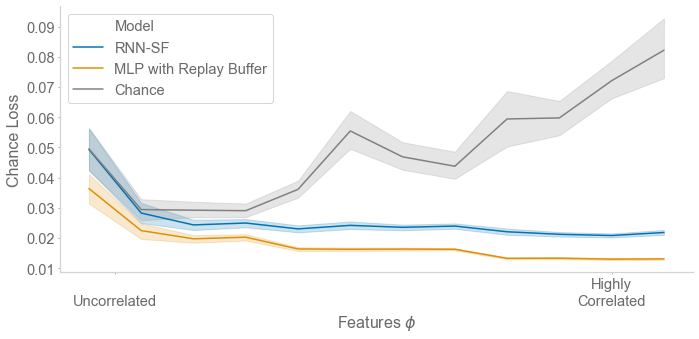

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(
    x='Sigma', y='Final Loss', hue='Model',
    ax = ax, data=df[(df['Gamma']==0.75)],
    hue_order=hue_order
    )
sns.lineplot(
    x='Sigma', y='Chance Loss',
    ax = ax, data=df[(df['Gamma']==0.75) & (df['Model']=='RNN-SF')],
    color='Gray', label='Chance'
    )
plt.xticks([0.5, np.unique(sigmas).size-2], ['\nUncorrelated', 'Highly\nCorrelated'])
plt.xlabel('Features $\phi$')
plt.tight_layout()
plt.savefig('4a_corrlineplot.png', dpi=300)

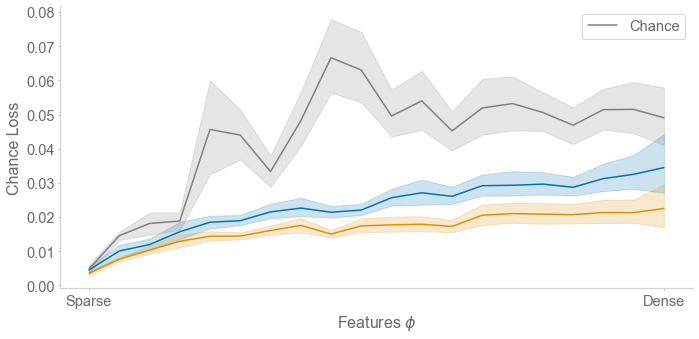

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(
    x='Sparsity', y='Final Loss', hue='Model',
    ax = ax, data=df[df['Gamma']==0.75],
    hue_order=hue_order, legend=None
    )
sns.lineplot(
    x='Sparsity', y='Chance Loss',
    ax = ax, data=df[(df['Gamma']==0.75) & (df['Model']=='RNN-SF')],
    color='Gray', label='Chance'
    )
xtick1 = df['Sparsity'].min()
xtick2 = df['Sparsity'].max()
plt.xticks([xtick1, xtick2], ['Sparse', 'Dense'])
plt.xlabel('Features $\phi$')
plt.tight_layout()
plt.savefig('4a_sparselineplot.png', dpi=300)

# Make 2D plots

In [16]:
np.unique(models)

array(['Linear', 'MLP with Replay Buffer', 'RNN-Oja', 'RNN-SF'],
      dtype='<U22')

In [17]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression

In [116]:
def get_edge_nans(im):
    """ im is processed row-by-row (e.g., sigma by sparsity) """
    
    mask = np.zeros(im.shape).astype(bool)
    nrows, ncols = im.shape
    for i in range(nrows):
        j = 0
        while np.isnan(im[i,j]) and (j < ncols):
            mask[i,j] = True
            j += 1
    return mask

In [117]:
plt.rcParams.update({'hatch.color': 'darkgray'})

In [122]:
def make_gradients(
    xs, ys, zs, models, cmap="Reds",
    plottype='RNN-SF', chance_relative=False, chance_zs=None,
    title=None, xlabel=None, ylabel=None,
    figname=None, figsize=[6.4, 4.8],
    interpolate=False, smooth=False, contours=None,
    leave_edge_nans=True, xlim=None
    ):
    
    # Collect data into a meshgrid
    xs = xs.astype(float)
    ys = ys.astype(float)
    zs = zs.astype(float)
    x_list = np.sort(np.unique(xs))
    y_list = np.sort(np.unique(ys))
    dxs = np.around(x_list[1:] - x_list[:-1], decimals=2)
    dys = np.around(y_list[1:] - y_list[:-1], decimals=2)
    if np.unique(dxs).size > 1 or np.unique(dys).size > 1:
        if smooth:
            print("Warning: Smoothing with inconsistent dx/dy")
    x_list = np.concatenate((x_list, [x_list[-1]+dxs[-1]]))
    y_list = np.concatenate((y_list, [y_list[-1]+dys[-1]]))
    x, y = np.meshgrid(x_list, y_list)
    z = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(y.shape[1]):
            ij_idx = np.logical_and(
                np.logical_and(xs==x[i,j], ys==y[i,j]),
                models==plottype
                )
            _val = np.nanmean(zs[ij_idx])
            if chance_relative:
                _chance_val = np.nanmean(chance_zs[ij_idx])
                val = _chance_val/_val
            else:
                val = _val
            z[i,j] = val
    cmap = plt.get_cmap(cmap)
    cmap.set_bad('yellow')
    
    # Plot raw grid values
    fig, ax = plt.subplots()
    im = ax.pcolormesh(
        x, y, z, cmap=cmap
        )
    fig.colorbar(im, ax=ax)
    plt.show()
    
    # Remove padding used for pcolormesh plot
    x = x[:-1,:-1]
    y = y[:-1,:-1]
    z = z[:-1,:-1]
            
        
    # Mark NaNs
    nan_mask = np.isnan(z)
    edge_nan_mask = get_edge_nans(z)

    if interpolate:
        if np.sum(nan_mask) > 0:
            nonnan_mask = np.logical_not(nan_mask)
            nan_indices = np.argwhere(nan_mask)
            data_X = np.vstack(
                [x[nonnan_mask].flatten(),
                 y[nonnan_mask].flatten()]).T
            data_y = z[nonnan_mask].flatten()
            reg = LinearRegression().fit(data_X, data_y)

            interp_vals = reg.predict(
                np.vstack(
                [x[nan_mask].flatten(),
                 y[nan_mask].flatten()]).T
                )
            z[nan_mask] = interp_vals

    # Smooth over cells to denoise
    if smooth:
        from astropy.convolution import Gaussian2DKernel
        from astropy.convolution import convolve
        kernel = Gaussian2DKernel(x_stddev=1, y_stddev=1)
        z = convolve(z, kernel, preserve_nan=True)
    
    # Generate contour plots
    levels = MaxNLocator(nbins=20).tick_values(np.nanmin(z), np.nanmax(z))
    fig, ax = plt.subplots(figsize=figsize)

    cf = ax.contourf(x, y, z,
                     levels=levels, cmap=cmap
                     )
    if leave_edge_nans: # White out parts that were extrapolated
        nans = np.argwhere(edge_nan_mask)
        nan1 = nans[0]; nan2 = nans[-1]
        nan1x = x[nan1[0],nan1[1]]
        nan1y = y[nan1[0],nan1[1]]
        nan2x = x[nan2[0],nan2[1]]
        nan2y = y[nan2[0],nan2[1]]
        max_y = y.max()
        plt.fill(
            [nan1x, nan2x, nan1x],
            [nan1y, nan2y, max_y],
            color='white'
            )
    if xlim is not None: # Adjust x limits
        plt.xlim(xlim)
    if contours is not None: # Draw contours
        cntrs = plt.contourf(
            x, y, z, contours,
            hatches='//', alpha=0.01,
            colors='white'
            )
        plt.clabel(cntrs, inline=True, fontsize=12)
    fig.colorbar(cf, ax=ax)
    ax.set_title('contourf with levels')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.tight_layout()
    plt.savefig(f'{figname}.png', dpi=300)
    plt.show()
    
    return x, y, z

In [137]:
_gamma = 0.8

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  Thi

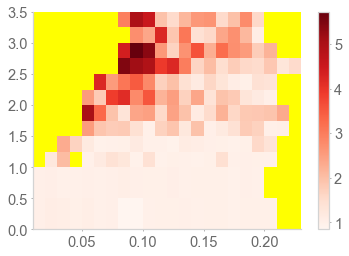

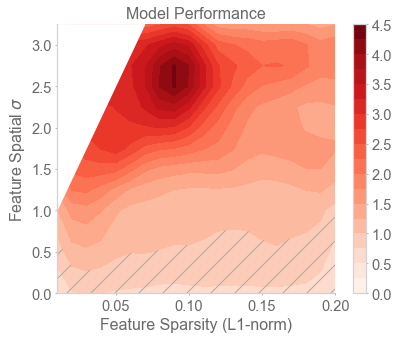

In [138]:
# RNN-SF
_models = models[gammas==_gamma]
_sparsities = final_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]
_chance_losses = chance_losses[gammas==_gamma]

_x, _y, _z = make_gradients(
    _sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'4a_perf_rnn_{_gamma}',
    interpolate=True, smooth=True, figsize=[6,5],
    plottype='RNN-SF', chance_relative=True,
    chance_zs = _chance_losses, contours=[0.0, 1.0],
    xlim=[_sparsities.min(), 0.2]
    )

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  Thi

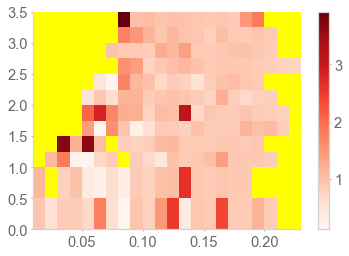

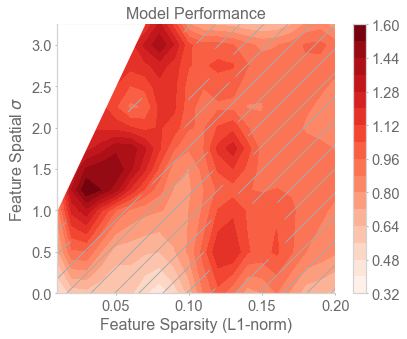

In [139]:
# RNN-Oja
_models = models[gammas==_gamma]
_sparsities = final_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]
_chance_losses = chance_losses[gammas==gamma]

_x, _y, _z = make_gradients(
    _sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'4a_perf_rnn_oja_{_gamma}',
    interpolate=True, smooth=True, figsize=[6,5],
    plottype='RNN-Oja', chance_relative=True,
    chance_zs = _chance_losses, contours=[0.0, 1.0],
    xlim=[_sparsities.min(), 0.2]
    )

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  Thi

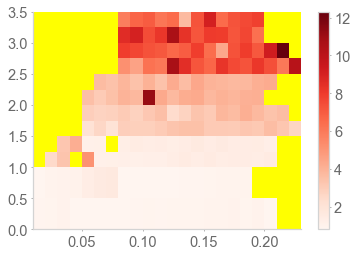

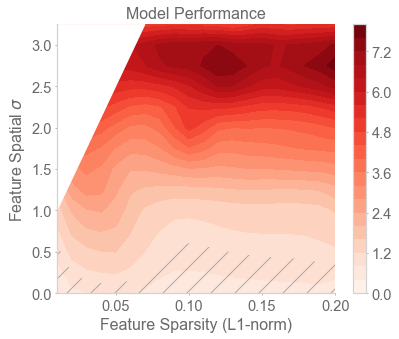

In [140]:
# Linear
_models = models[gammas==_gamma]
_sparsities = final_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]
_chance_losses = chance_losses[gammas==gamma]

_x, _y, _z = make_gradients(
    _sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'4a_perf_linear_{_gamma}',
    interpolate=True, smooth=True, figsize=[6,5],
    plottype='Linear', chance_relative=True,
    chance_zs = _chance_losses, contours=[0.0, 1.0],
    xlim=[_sparsities.min(), 0.2]
    )